In [1]:
category = ['low', 'mid', 'high'][2]
SM_RDst = 0.33
version = 'v0'
reTrain = False

# Import

In [2]:
import sys, os, pickle, time
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
from categoriesDef import categories
cat = categories[category]
import json, yaml

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from array import array
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from pT_calibration_reader import pTCalReader
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist
from gridVarQ2Plot import plot_gridVarQ2, plot_SingleCategory
from progressBar import ProgressBar

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "       Simulation Preliminary"

Welcome to JupyROOT 6.20/07


In [4]:
#They all have to be produced with the same pileup
MCsample = {
'tau' : DSetLoader('B0_TauNuDmst_PUc0'),
'mu' : DSetLoader('B0_MuNuDmst_PUc0'),
'DstmD0' : DSetLoader('B0_DstmD0_PUc0'),
'DstmDp' : DSetLoader('B0_DstmDp_PUc0'),
'DstmDsp' : DSetLoader('B0_DstmDsp_PUc0'),
'BpDstmHc' : DSetLoader('Bp_DstmHc_PUc0'),
'BmDstmHc' : DSetLoader('Bm_DstmHc_PUc0'),
'antiB0DstmHc' : DSetLoader('antiB0_DstmHc_PUc0'),
'DstPip' : DSetLoader('Bp_MuNuDstst_Pip_PUc0'),
'DstPi0' : DSetLoader('B0_MuNuDstst_Pi0_PUc0'),
'DstPipPi0' : DSetLoader('Bp_MuNuDstst_PipPi0_PUc0'),
'DstPipPim' : DSetLoader('B0_MuNuDstst_PipPim_PUc0'),
'DstPi0Pi0' : DSetLoader('B0_MuNuDstst_Pi0Pi0_PUc0'),
}
processOrder = ['tau', 'mu', 'DstPip','DstPi0','DstPipPi0','DstPipPim','DstPi0Pi0','DstmDsp','DstmD0','DstmDp','BpDstmHc','BmDstmHc','antiB0DstmHc']
dSet = {}
for n, s in MCsample.iteritems():
    if not n in processOrder: raise
    dSet[n] = rtnp.root2array(s.skimmed_dir + '/{}_corr.root'.format(cat.name))

../lib/analysis_utilities.py:115: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  samples = yaml.load(open(sampleFile))['samples']
../lib/analysis_utilities.py:143: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.effMCgen = yaml.load(open(effMCgenFile, 'r'))
../lib/analysis_utilities.py:147: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.effCand = yaml.load(open(effCandFile, 'r'))


In [5]:
expectedLumi = {'low':6.4, 'mid':20.7, 'high':26.4, 'single':6.} #fb^-1
lumi_tot = expectedLumi[category]
CMS_lumi.integrated_lumi = lumi_tot

# Load corrections

In [6]:
from pileup_utilities import pileupReweighter
puReweighter = pileupReweighter(MCsample['mu'].skimmed_dir + '/{}_corr.root'.format(cat.name), cat)

In [7]:
decayBR = pickle.load(open('../data/forcedDecayChannelsFactors.pickle', 'rb'))

In [8]:
loc = '../data/calibration/triggerScaleFactors/'
fTriggerSF = rt.TFile.Open(loc + 'HLT_' + cat.trg + '_SF_v3.root', 'READ')
hTriggerSF = fTriggerSF.Get('hSF_HLT_' + cat.trg)

def computeTrgSF(ds, selection=None):
    trgSF = np.ones_like(ds['q2'])
    trgSFUnc = np.zeros_like(ds['q2'])
    ptmax = hTriggerSF.GetXaxis().GetXmax() - 0.01
    ipmax = hTriggerSF.GetYaxis().GetXmax() - 0.01
    etamax = hTriggerSF.GetZaxis().GetXmax() - 0.01
    x = np.column_stack((ds['mu_pt'], ds['mu_eta'], ds['mu_sigdxy']))
    if not selection is None:
        x = x[selection]
    for i, (pt, eta, ip) in enumerate(x):
        ix = hTriggerSF.GetXaxis().FindBin(min(ptmax, pt))
        iy = hTriggerSF.GetYaxis().FindBin(min(ipmax, ip))
        iz = hTriggerSF.GetZaxis().FindBin(min(etamax, np.abs(eta)))
        trgSF[i] = hTriggerSF.GetBinContent(ix, iy, iz)
        if trgSF[i] == 0:
            print pt, ip, np.abs(eta)
            raise
    return trgSF

In [9]:
fMuonIDSF = rt.TFile.Open('../data/calibration/muonIDscaleFactors/Run2018ABCD_SF_MuonID_Jpsi.root', 'READ')
hMuonIDSF = fMuonIDSF.Get('NUM_SoftID_DEN_genTracks_pt_abseta')

def computeMuonIDSF(ds, selection=None):
    muonSF = np.ones_like(ds['q2'])
    muonSFUnc = np.zeros_like(ds['q2'])
    ptmax = hMuonIDSF.GetXaxis().GetXmax() - 0.01
    etamax = hMuonIDSF.GetYaxis().GetXmax() - 0.01
    x = np.column_stack((ds['MC_mu_pt'], ds['MC_mu_eta']))
    if not selection is None:
        x = x[selection]
    for i, (pt, eta) in enumerate(x):
        ix = hMuonIDSF.GetXaxis().FindBin(min(pt, ptmax))
        if ix == 0: ix = 1 #Remove underflows (Meaning that the MC matching failed)
        iy = hMuonIDSF.GetYaxis().FindBin(min(np.abs(eta), etamax))
        muonSF[i] = hMuonIDSF.GetBinContent(ix, iy)
        if muonSF[i] == 0:
            print pt, eta
            print ix, iy
            raise
    return muonSF

In [10]:
cal_pT = pTCalReader(calibration_file='../data/calibration/B0pTspectrum/pwWeights_{}.txt'.format(cat.name))

# Create dataset

In [11]:
sampleWeights = {}
sampleX = {}

RDoMC_normRatio = 2.5 # Ad hoc overall scale corr
for n in processOrder:
    print '\n----------->', n, '<-------------'
    ds = dSet[n]
    sMC = MCsample[n]
    
    nTotSelected = ds['q2'].shape[0]
    print 'N tot selected: {:.1f}k'.format(1e-3*nTotSelected)
    nGenExp = sMC.effMCgen['xsec'][0] * lumi_tot * RDoMC_normRatio
    if n == 'tau':
        nGenExp *= SM_RDst
    eff = [1, 0]
    for f, df in [sMC.effMCgen['effGEN'], decayBR[n], sMC.effCand['effCAND'], sMC.getSkimEff(cat.name+'_corr')]:
        eff[0] *= f
        eff[1] += np.square(df/f)
    eff[1] = eff[0] * np.sqrt(eff[1])
    nTotExp = nGenExp*eff[0]
    print 'N tot expected (before weights): {:.2f}k'.format(1e-3*nTotExp)
    
    weightsCentral = puReweighter.weightsPileupMC[ds['N_vtx'].astype(np.int)]
    weightsCentral *= computeTrgSF(ds)
    weightsCentral *= computeMuonIDSF(ds)
    if n in ['mu', 'tau', 'DstmD0', 'DstmDp', 'DstmDsp','DstPi0', 'DstPipPim', 'DstPi0Pi0']: #B0 dominated final states (probably we should do something about B+ too)
        weightsCentral *= cal_pT.f['C'](ds['MC_B_pt'])
    if n in ['mu', 'tau']:
        weightsCentral *= ds['wh_CLNCentral']*sMC.effCand['rate_den']/sMC.effCand['rate_Central']
    weightsCentral *= nTotExp/nTotSelected
    print 'N tot expected (after weights): {:.3f}k'.format(1e-3*np.sum(weightsCentral))
    sampleWeights[n] = weightsCentral
    sampleX[n] = np.column_stack((ds['q2'], ds['Est_mu'], ds['M2_miss']))
del dSet


-----------> tau <-------------
N tot selected: 29.6k
N tot expected (before weights): 3.81k
N tot expected (after weights): 4.105k

-----------> mu <-------------
N tot selected: 495.6k
N tot expected (before weights): 389.87k
N tot expected (after weights): 399.817k

-----------> DstPip <-------------
N tot selected: 17.7k
N tot expected (before weights): 7.63k
N tot expected (after weights): 7.935k

-----------> DstPi0 <-------------
N tot selected: 34.2k
N tot expected (before weights): 13.67k
N tot expected (after weights): 14.449k

-----------> DstPipPi0 <-------------
N tot selected: 1.6k
N tot expected (before weights): 0.72k
N tot expected (after weights): 0.744k

-----------> DstPipPim <-------------
N tot selected: 0.7k
N tot expected (before weights): 0.36k
N tot expected (after weights): 0.372k

-----------> DstPi0Pi0 <-------------
N tot selected: 16.0k
N tot expected (before weights): 1.40k
N tot expected (after weights): 1.475k

-----------> DstmDsp <-------------
N to

# Exploratory Plots

In [12]:
weightsBkg = np.array([])
xBkg = np.zeros((0,3))
for n in sampleWeights.keys():
    if not n in ['tau', 'mu']:
        weightsBkg = np.concatenate((weightsBkg, sampleWeights[n]))
        xBkg = np.concatenate((xBkg, sampleX[n]))

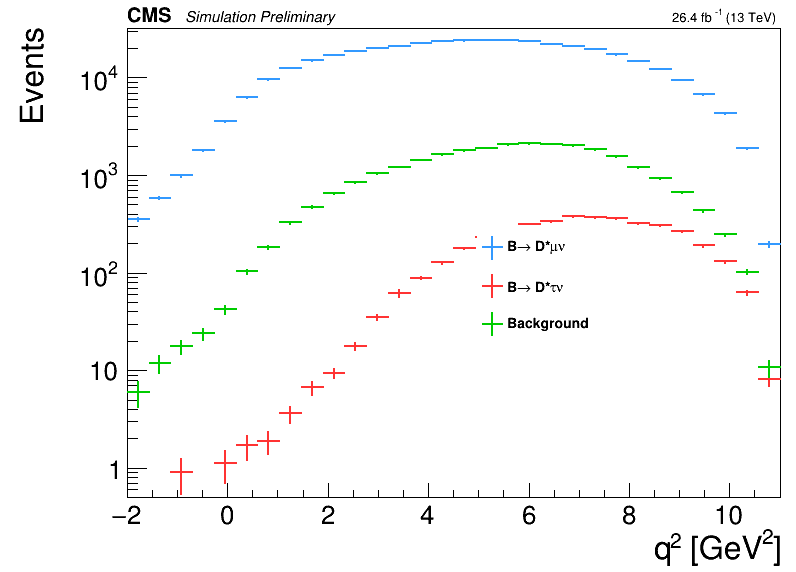

In [13]:
#q2
leg = rt.TLegend(0.6, 0.4, 0.75, 0.6)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

hl = []
h = create_TH1D(sampleX['mu'][:, 0], weights=sampleWeights['mu'],
                binning=[30,-2,11.], color=0, axis_title=['q^{2} [GeV^{2}]', 'Events'])
hl.append(h)
leg.AddEntry(h, 'B#rightarrow D*#mu#nu', 'lep')

h = create_TH1D(sampleX['tau'][:, 0], weights=sampleWeights['tau'], binning=hl[0].binning, color=1)
hl.append(h)
leg.AddEntry(h, 'B#rightarrow D*#tau#nu', 'lep')

h = create_TH1D(xBkg[:, 0], weights=weightsBkg, binning=hl[0].binning, color=2)
hl.append(h)
leg.AddEntry(h, 'Background', 'lep')


m = SetMaxToMaxHist(hl)
hl[0].GetYaxis().SetRangeUser(0.5, m*1.2)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
c.SetLogy()
leg.Draw()

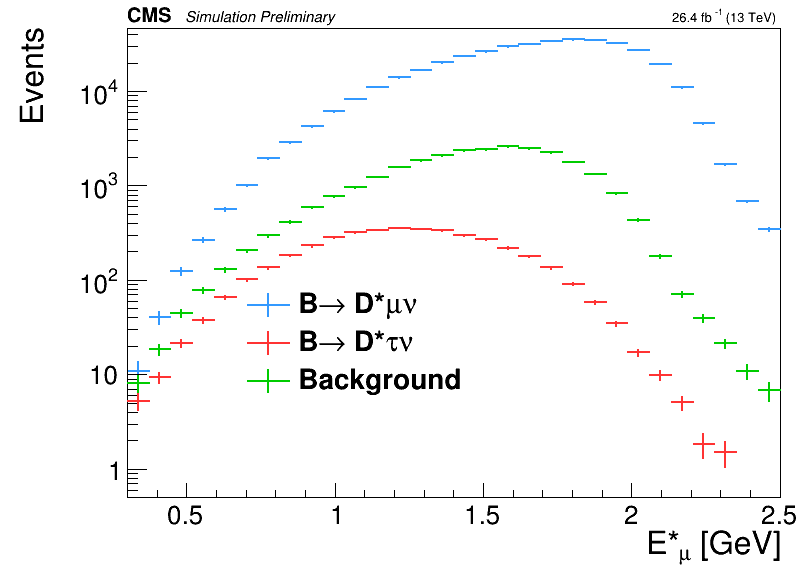

In [14]:
#Est_mu
leg = rt.TLegend(0.3, 0.3, 0.6, 0.5)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

hl = []
h = create_TH1D(sampleX['mu'][:, 1], weights=sampleWeights['mu'],
                binning=[30,0.3,2.5], color=0, axis_title=['E*_{#mu} [GeV]', 'Events'])
hl.append(h)
leg.AddEntry(h, 'B#rightarrow D*#mu#nu', 'lep')

h = create_TH1D(sampleX['tau'][:, 1], weights=sampleWeights['tau'], binning=hl[0].binning, color=1)
hl.append(h)
leg.AddEntry(h, 'B#rightarrow D*#tau#nu', 'lep')

h = create_TH1D(xBkg[:, 1], weights=weightsBkg, binning=hl[0].binning, color=2)
hl.append(h)
leg.AddEntry(h, 'Background', 'lep')


m = SetMaxToMaxHist(hl)
hl[0].GetYaxis().SetRangeUser(0.5, m*1.2)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
c.SetLogy()
leg.Draw()

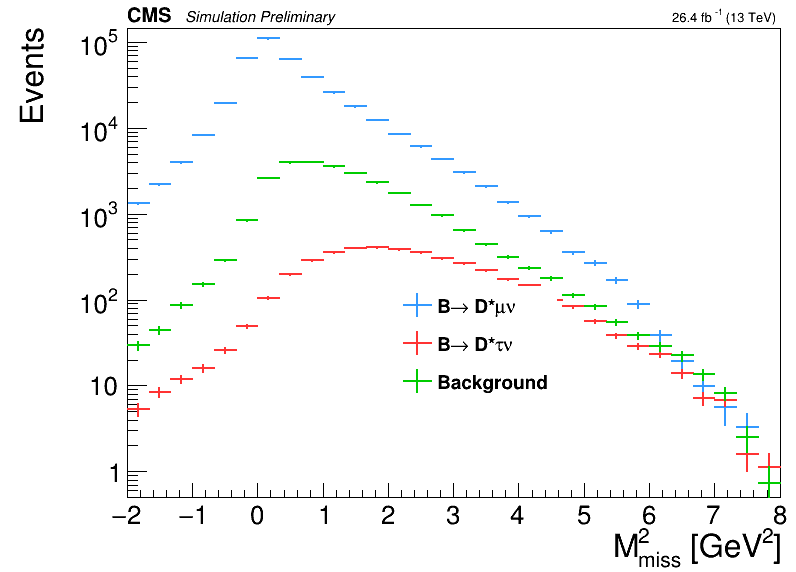

In [15]:
#M2miss
leg = rt.TLegend(0.5, 0.3, 0.7, 0.5)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

hl = []
h = create_TH1D(sampleX['mu'][:, 2], weights=sampleWeights['mu'],
                binning=[30,-2,8], color=0, axis_title=['M^{2}_{miss} [GeV^{2}]', 'Events'])
hl.append(h)
leg.AddEntry(h, 'B#rightarrow D*#mu#nu', 'lep')

h = create_TH1D(sampleX['tau'][:, 2], weights=sampleWeights['tau'], binning=hl[0].binning, color=1)
hl.append(h)
leg.AddEntry(h, 'B#rightarrow D*#tau#nu', 'lep')

h = create_TH1D(xBkg[:, 2], weights=weightsBkg, binning=hl[0].binning, color=2)
hl.append(h)
leg.AddEntry(h, 'Background', 'lep')


m = SetMaxToMaxHist(hl)
hl[0].GetYaxis().SetRangeUser(0.5, m*1.2)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
c.SetLogy()
leg.Draw()

In [16]:
np.set_printoptions(precision=2)
print 'Mu\n', np.corrcoef(sampleX['mu'].T)
print '\n\n'
print 'Tau\n', np.corrcoef(sampleX['tau'].T)
print '\n\n'
print 'Bkg\n', np.corrcoef(xBkg.T)

Mu
[[ 1.   -0.17  0.35]
 [-0.17  1.   -0.55]
 [ 0.35 -0.55  1.  ]]



Tau
[[ 1.   -0.2   0.55]
 [-0.2   1.   -0.75]
 [ 0.55 -0.75  1.  ]]



Bkg
[[ 1.   -0.21  0.55]
 [-0.21  1.   -0.74]
 [ 0.55 -0.74  1.  ]]


In [17]:
legendTxt = ['B#rightarrow D*#mu#nu', 'B#rightarrow D*#tau#nu', 'Background']
l = rt.TLatex()
l.SetTextAlign(11)
l.SetTextSize(0.05)
l.SetTextFont(42)

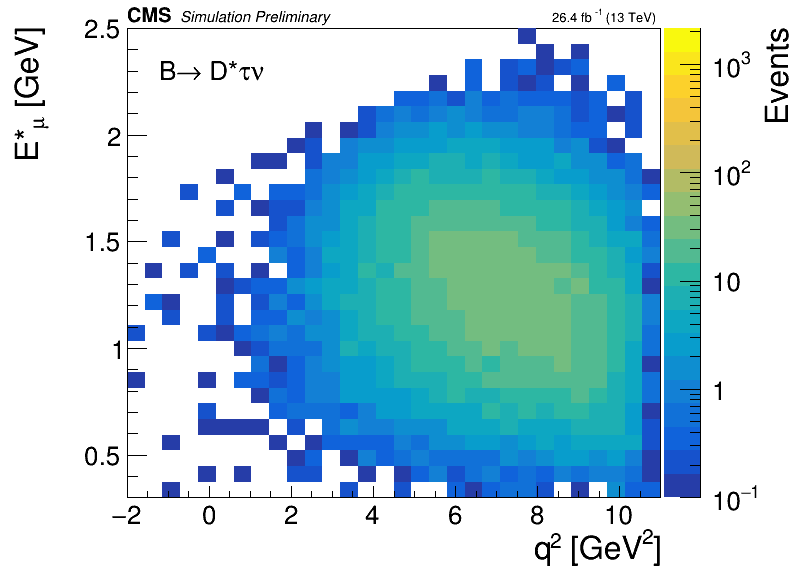

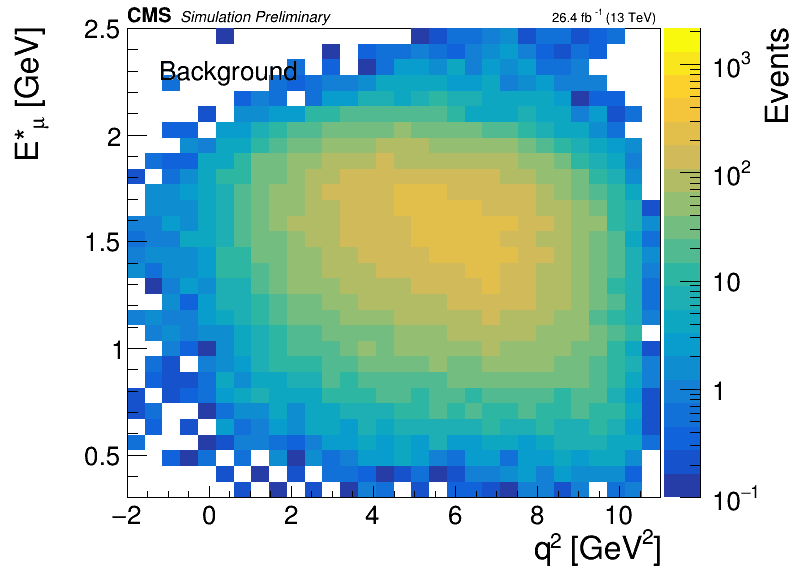

In [18]:
#q2 vs Est_mu
hl = []
h = create_TH2D(sampleX['mu'][:, 0:2], weights=sampleWeights['mu'],
                binning=[30, -2, 11, 30, 0.3, 2.5], axis_title=['q^{2} [GeV^{2}]', 'E*_{#mu} [GeV]', 'Events'])
hl.append(h)

h = create_TH2D(sampleX['tau'][:, 0:2], weights=sampleWeights['tau'], 
                binning=hl[0].binning, axis_title=h.axis_title)
hl.append(h)

h = create_TH2D(xBkg[:, 0:2], weights=weightsBkg, 
                binning=hl[0].binning, axis_title=h.axis_title)
hl.append(h)

M = np.max([h.GetMaximum() for h in hl])
for h in hl:
    h.GetZaxis().SetRangeUser(0.1, M)

for i, h in enumerate(hl):
    c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag=str(i), mR=0.17)
    c.Draw()
    c.SetLogz()
    l.DrawLatexNDC(0.2, 0.86, legendTxt[i])

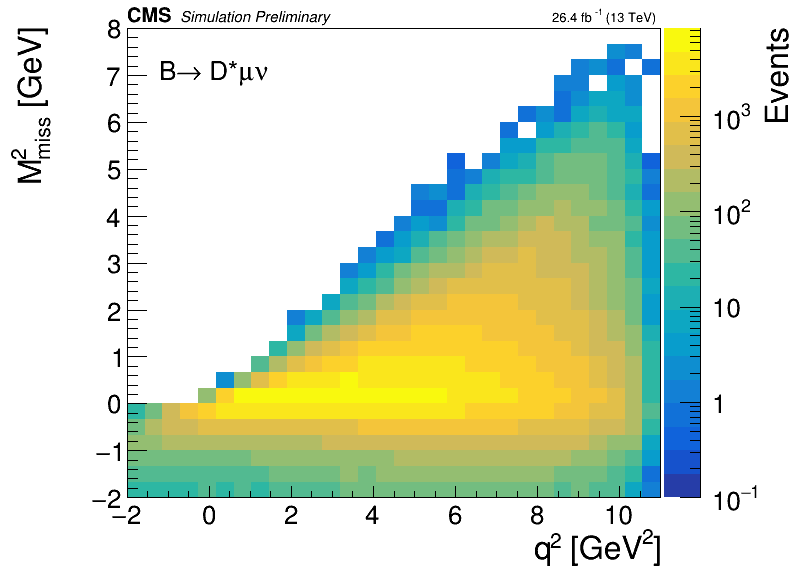

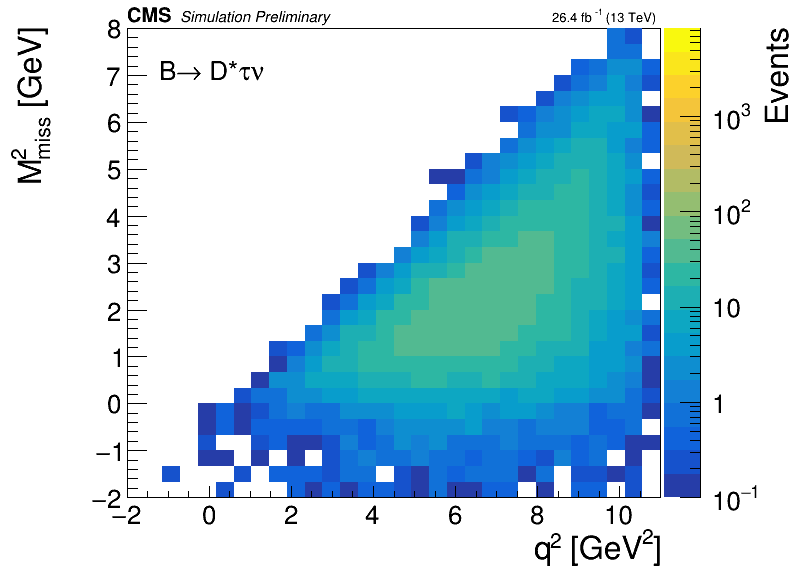

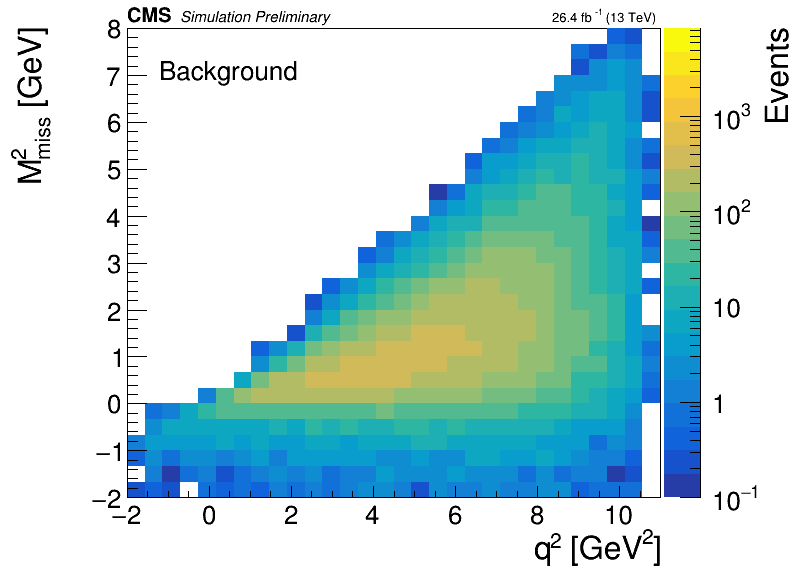

In [19]:
#q2 vs M2miss
hl = []
h = create_TH2D(sampleX['mu'][:, np.array([0,2])], weights=sampleWeights['mu'],
                binning=[30, -2, 11, 30,-2,8], axis_title=['q^{2} [GeV^{2}]', 'M^{2}_{miss} [GeV]', 'Events'])
hl.append(h)

h = create_TH2D(sampleX['tau'][:, np.array([0,2])], weights=sampleWeights['tau'], 
                binning=hl[0].binning, axis_title=h.axis_title)
hl.append(h)

h = create_TH2D(xBkg[:, np.array([0,2])], weights=weightsBkg, 
                binning=hl[0].binning, axis_title=h.axis_title)
hl.append(h)

M = np.max([h.GetMaximum() for h in hl])
for h in hl:
    h.GetZaxis().SetRangeUser(0.1, M)

for i, h in enumerate(hl):
    c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag=str(i), mR=0.17)
    c.Draw()
    c.SetLogz()
    l.DrawLatexNDC(0.2, 0.86, legendTxt[i])

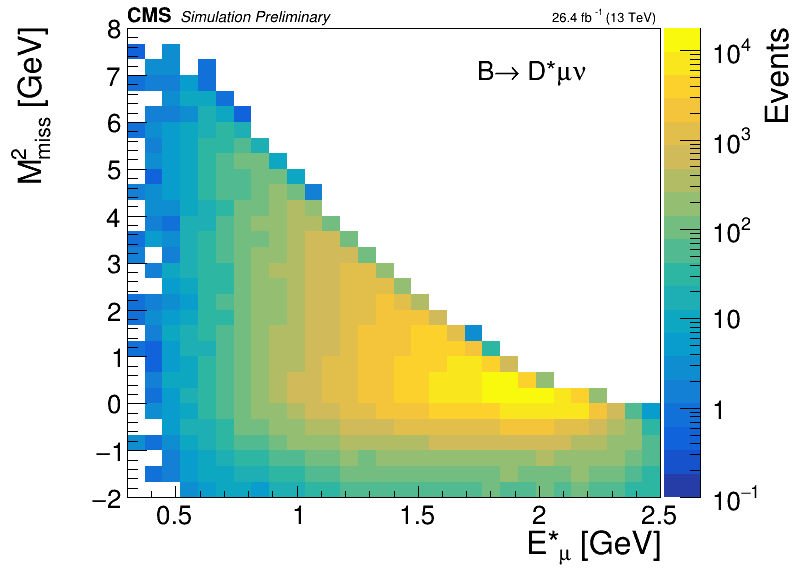

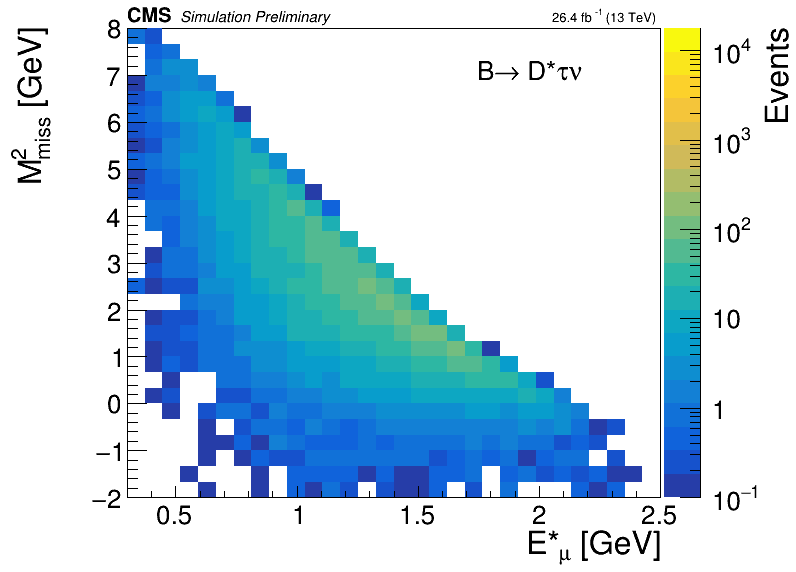

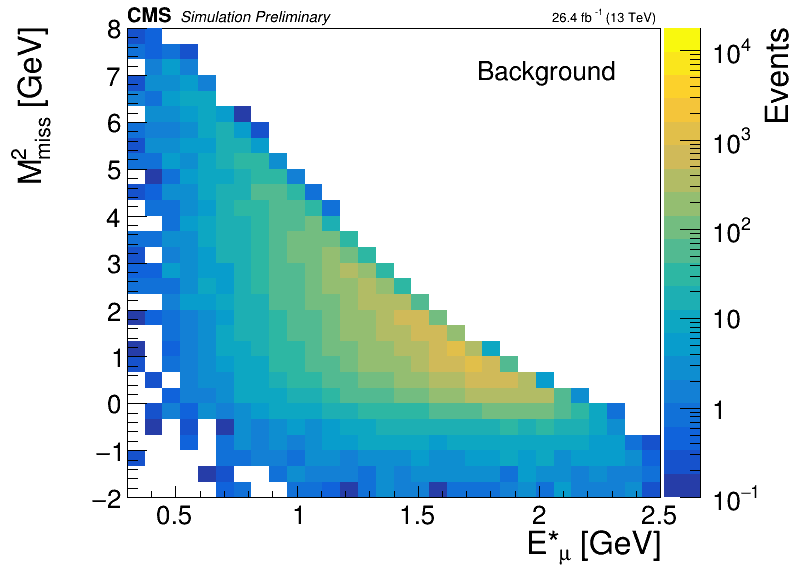

In [20]:
#Estmu vs M2miss
hl = []
h = create_TH2D(sampleX['mu'][:, np.array([1,2])], weights=sampleWeights['mu'],
                binning=[30, 0.3, 2.5, 30,-2,8], axis_title=['E*_{#mu} [GeV]', 'M^{2}_{miss} [GeV]', 'Events'])
hl.append(h)

h = create_TH2D(sampleX['tau'][:, np.array([1,2])], weights=sampleWeights['tau'], 
                binning=hl[0].binning, axis_title=h.axis_title)
hl.append(h)

h = create_TH2D(xBkg[:, np.array([1,2])], weights=weightsBkg, 
                binning=hl[0].binning, axis_title=h.axis_title)
hl.append(h)

M = np.max([h.GetMaximum() for h in hl])
for h in hl:
    h.GetZaxis().SetRangeUser(0.1, M)

for i, h in enumerate(hl):
    c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag=str(i), mR=0.17)
    c.Draw()
    c.SetLogz()
    l.DrawLatexNDC(0.6, 0.86, legendTxt[i])

# Two samples splitting (Tau vs All)

In [21]:
# weightsBkg = np.array([])
# xBkg = np.zeros((0,3))
# for n in sampleWeights.keys():
#     if not n == 'tau':
#         weightsBkg = np.concatenate((weightsBkg, sampleWeights[n]))
#         xBkg = np.concatenate((xBkg, sampleX[n]))

# wTot = np.sum(weightsBkg) + np.sum(sampleWeights['tau'])
# fBkg = np.sum(weightsBkg)/wTot
# fSig = np.sum(sampleWeights['tau'])/wTot
# print fBkg
# print fSig

In [22]:
weightsBkg = np.array([])
xBkg = np.zeros((0,3))
for n in sampleWeights.keys():
    if not n in ['tau', 'mu']:
        weightsBkg = np.concatenate((weightsBkg, sampleWeights[n]))
        xBkg = np.concatenate((xBkg, sampleX[n]))

wTot = np.sum(weightsBkg) + np.sum(sampleWeights['tau']) + np.sum(sampleWeights['mu'])
fBkg = np.sum(weightsBkg)/wTot
fTau = np.sum(sampleWeights['tau'])/wTot
fMu = np.sum(sampleWeights['mu'])/wTot
print fTau, fMu, fBkg

0.00952234893254834 0.9275662721810202 0.06291137888643142


In [23]:
X = np.concatenate((xBkg, sampleX['tau'], sampleX['mu']))
weights = np.concatenate((weightsBkg/fBkg, sampleWeights['tau']/fTau, sampleWeights['mu']/fMu))

yBkg = np.zeros_like(weightsBkg)
yMu = np.zeros_like(sampleWeights['mu'])
yTau = np.ones_like(sampleWeights['tau'])
y = np.concatenate((yBkg, yTau, yMu))

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.1, random_state=0)

## BDT Classifier

In [24]:
fname = './kinObsMVA/clfGBC_tauVall_{}{}.p'.format(version, cat.name)
if reTrain or not os.path.exists(fname):
    clfGBC = GradientBoostingClassifier(
        learning_rate=0.0005, 
        n_estimators=100000, 
        min_samples_split=5, 
        min_weight_fraction_leaf=5e-4, 
        max_depth=3,
        validation_fraction=0.20,
        n_iter_no_change=250,
        tol=0.00001,
#         ccp_alpha=1e-4,
        verbose=2,
        random_state=0
    )

    clfGBC.fit(X_train, y_train, sample_weight=w_train)
    pickle.dump(clfGBC, open(fname, 'wb')) 
else:
    clfGBC = pickle.load(open(fname, 'rb'))
    
sTrain = clfGBC.score(X_train, y_train, sample_weight=w_train)
sTest = clfGBC.score(X_test, y_test, sample_weight=w_test)
print 'Accuracy: {:.5f} (train), {:.5f} (test)'.format(sTrain, sTest)

      Iter       Train Loss   Remaining Time 
         1           1.2730          575.26m
         2           1.2727          587.79m
         3           1.2725          587.88m
         4           1.2723          590.73m
         5           1.2720          592.66m
         6           1.2718          592.46m
         7           1.2716          591.95m
         8           1.2713          593.94m
         9           1.2711          593.54m
        10           1.2708          593.19m
        11           1.2706          592.57m
        12           1.2704          592.01m
        13           1.2701          593.34m
        14           1.2699          592.91m
        15           1.2697          593.99m
        16           1.2694          594.33m
        17           1.2692          593.75m
        18           1.2689          593.42m
        19           1.2687          594.35m
        20           1.2685          594.11m
        21           1.2682          593.88m
        2

       183           1.2332          592.68m
       184           1.2330          592.64m
       185           1.2328          592.57m
       186           1.2326          593.87m
       187           1.2324          595.40m
       188           1.2322          595.32m
       189           1.2320          595.47m
       190           1.2318          595.41m
       191           1.2316          595.40m
       192           1.2314          595.36m
       193           1.2312          595.29m
       194           1.2310          595.23m
       195           1.2308          595.20m
       196           1.2306          595.14m
       197           1.2305          595.10m
       198           1.2303          595.05m
       199           1.2301          594.99m
       200           1.2299          594.94m
       201           1.2297          594.86m
       202           1.2295          594.78m
       203           1.2293          594.72m
       204           1.2291          594.70m
       205

       366           1.1999          593.36m
       367           1.1998          593.32m
       368           1.1996          593.29m
       369           1.1994          593.25m
       370           1.1993          593.21m
       371           1.1991          593.18m
       372           1.1989          593.16m
       373           1.1988          593.12m
       374           1.1986          593.11m
       375           1.1984          593.08m
       376           1.1983          593.04m
       377           1.1981          593.06m
       378           1.1979          593.03m
       379           1.1978          592.99m
       380           1.1976          592.98m
       381           1.1974          592.94m
       382           1.1973          592.91m
       383           1.1971          592.92m
       384           1.1970          593.16m
       385           1.1968          593.15m
       386           1.1966          593.11m
       387           1.1965          593.07m
       388

       549           1.1720          591.85m
       550           1.1718          591.83m
       551           1.1717          591.84m
       552           1.1715          591.83m
       553           1.1714          591.79m
       554           1.1713          591.80m
       555           1.1711          591.76m
       556           1.1710          591.77m
       557           1.1709          591.76m
       558           1.1707          591.74m
       559           1.1706          591.71m
       560           1.1704          591.69m
       561           1.1703          591.66m
       562           1.1702          591.66m
       563           1.1700          591.63m
       564           1.1699          591.59m
       565           1.1697          591.60m
       566           1.1696          591.58m
       567           1.1695          591.55m
       568           1.1693          591.56m
       569           1.1692          591.52m
       570           1.1691          591.50m
       571

       732           1.1483          589.58m
       733           1.1482          589.57m
       734           1.1481          589.57m
       735           1.1480          589.55m
       736           1.1479          589.53m
       737           1.1477          589.55m
       738           1.1476          589.52m
       739           1.1475          589.51m
       740           1.1474          589.53m
       741           1.1473          589.51m
       742           1.1472          589.50m
       743           1.1470          589.50m
       744           1.1469          589.49m
       745           1.1468          589.48m
       746           1.1467          589.49m
       747           1.1466          589.48m
       748           1.1464          589.47m
       749           1.1463          589.46m
       750           1.1462          589.44m
       751           1.1461          589.42m
       752           1.1460          589.41m
       753           1.1459          589.40m
       754

       915           1.1283          591.46m
       916           1.1282          591.43m
       917           1.1281          591.43m
       918           1.1280          591.41m
       919           1.1279          591.42m
       920           1.1278          591.41m
       921           1.1277          591.39m
       922           1.1276          591.36m
       923           1.1275          591.35m
       924           1.1274          591.33m
       925           1.1273          591.30m
       926           1.1272          591.29m
       927           1.1271          591.26m
       928           1.1270          591.23m
       929           1.1269          591.23m
       930           1.1268          591.20m
       931           1.1267          591.17m
       932           1.1266          591.16m
       933           1.1265          591.14m
       934           1.1264          591.13m
       935           1.1263          591.12m
       936           1.1262          591.09m
       937

      1098           1.1113          588.78m
      1099           1.1112          588.76m
      1100           1.1111          588.74m
      1101           1.1110          588.72m
      1102           1.1109          588.71m
      1103           1.1108          588.68m
      1104           1.1108          588.66m
      1105           1.1107          588.66m
      1106           1.1106          588.64m
      1107           1.1105          588.62m
      1108           1.1104          588.62m
      1109           1.1103          588.59m
      1110           1.1102          588.58m
      1111           1.1102          588.57m
      1112           1.1101          588.55m
      1113           1.1100          588.53m
      1114           1.1099          588.53m
      1115           1.1098          588.51m
      1116           1.1097          588.51m
      1117           1.1097          588.50m
      1118           1.1096          588.47m
      1119           1.1095          588.46m
      1120

      1281           1.0967          586.41m
      1282           1.0966          586.40m
      1283           1.0965          586.38m
      1284           1.0965          586.36m
      1285           1.0964          586.34m
      1286           1.0963          586.33m
      1287           1.0962          586.33m
      1288           1.0962          586.31m
      1289           1.0961          586.29m
      1290           1.0960          586.28m
      1291           1.0960          586.26m
      1292           1.0959          586.24m
      1293           1.0958          586.23m
      1294           1.0957          586.21m
      1295           1.0957          586.19m
      1296           1.0956          586.17m
      1297           1.0955          586.15m
      1298           1.0954          586.14m
      1299           1.0954          586.12m
      1300           1.0953          586.11m
      1301           1.0952          586.09m
      1302           1.0951          586.07m
      1303

      1464           1.0841          584.46m
      1465           1.0840          584.44m
      1466           1.0840          584.44m
      1467           1.0839          584.42m
      1468           1.0838          584.41m
      1469           1.0838          584.39m
      1470           1.0837          584.38m
      1471           1.0836          584.36m
      1472           1.0836          584.36m
      1473           1.0835          584.34m
      1474           1.0834          584.34m
      1475           1.0834          584.32m
      1476           1.0833          584.32m
      1477           1.0833          584.30m
      1478           1.0832          584.28m
      1479           1.0831          584.27m
      1480           1.0831          584.27m
      1481           1.0830          584.25m
      1482           1.0829          584.24m
      1483           1.0829          584.23m
      1484           1.0828          584.23m
      1485           1.0827          584.21m
      1486

      1647           1.0731          582.72m
      1648           1.0730          582.71m
      1649           1.0730          582.70m
      1650           1.0729          582.69m
      1651           1.0729          582.67m
      1652           1.0728          582.67m
      1653           1.0727          582.66m
      1654           1.0727          582.64m
      1655           1.0726          582.62m
      1656           1.0726          582.63m
      1657           1.0725          582.61m
      1658           1.0725          582.61m
      1659           1.0724          582.60m
      1660           1.0724          582.58m
      1661           1.0723          582.57m
      1662           1.0722          582.56m
      1663           1.0722          582.55m
      1664           1.0721          582.53m
      1665           1.0721          582.52m
      1666           1.0720          582.50m
      1667           1.0720          582.49m
      1668           1.0719          582.48m
      1669

      1830           1.0636          580.83m
      1831           1.0635          580.81m
      1832           1.0635          580.81m
      1833           1.0634          580.79m
      1834           1.0634          580.77m
      1835           1.0633          580.76m
      1836           1.0633          580.75m
      1837           1.0633          580.74m
      1838           1.0632          580.73m
      1839           1.0632          580.72m
      1840           1.0631          580.72m
      1841           1.0631          580.70m
      1842           1.0630          580.69m
      1843           1.0630          580.69m
      1844           1.0629          580.69m
      1845           1.0629          580.68m
      1846           1.0628          580.69m
      1847           1.0628          580.70m
      1848           1.0627          580.68m
      1849           1.0627          580.67m
      1850           1.0626          580.67m
      1851           1.0626          580.65m
      1852

      2013           1.0554          579.15m
      2014           1.0554          579.13m
      2015           1.0553          579.13m
      2016           1.0553          579.12m
      2017           1.0552          579.10m
      2018           1.0552          579.11m
      2019           1.0552          579.09m
      2020           1.0551          579.08m
      2021           1.0551          579.08m
      2022           1.0550          579.07m
      2023           1.0550          579.06m
      2024           1.0549          579.05m
      2025           1.0549          579.04m
      2026           1.0549          579.03m
      2027           1.0548          579.03m
      2028           1.0548          579.02m
      2029           1.0547          579.01m
      2030           1.0547          579.01m
      2031           1.0547          578.99m
      2032           1.0546          578.98m
      2033           1.0546          578.97m
      2034           1.0545          578.97m
      2035

      2196           1.0482          577.76m
      2197           1.0481          577.76m
      2198           1.0481          577.75m
      2199           1.0481          577.75m
      2200           1.0480          577.75m
      2201           1.0480          577.73m
      2202           1.0479          577.73m
      2203           1.0479          577.72m
      2204           1.0479          577.71m
      2205           1.0478          577.70m
      2206           1.0478          577.69m
      2207           1.0478          577.68m
      2208           1.0477          577.67m
      2209           1.0477          577.66m
      2210           1.0476          577.64m
      2211           1.0476          577.64m
      2212           1.0476          577.63m
      2213           1.0475          577.61m
      2214           1.0475          577.60m
      2215           1.0475          577.59m
      2216           1.0474          577.59m
      2217           1.0474          577.57m
      2218

      2379           1.0417          576.47m
      2380           1.0417          576.46m
      2381           1.0417          576.45m
      2382           1.0416          576.44m
      2383           1.0416          576.43m
      2384           1.0416          576.43m
      2385           1.0415          576.42m
      2386           1.0415          576.42m
      2387           1.0415          576.41m
      2388           1.0414          576.41m
      2389           1.0414          576.39m
      2390           1.0414          576.39m
      2391           1.0413          576.38m
      2392           1.0413          576.38m
      2393           1.0413          576.38m
      2394           1.0412          576.37m
      2395           1.0412          576.36m
      2396           1.0412          576.35m
      2397           1.0411          576.35m
      2398           1.0411          576.34m
      2399           1.0411          576.34m
      2400           1.0410          576.33m
      2401

      2562           1.0360          575.20m
      2563           1.0359          575.19m
      2564           1.0359          575.19m
      2565           1.0359          575.19m
      2566           1.0358          575.18m
      2567           1.0358          575.17m
      2568           1.0358          575.16m
      2569           1.0358          575.15m
      2570           1.0357          575.15m
      2571           1.0357          575.14m
      2572           1.0357          575.13m
      2573           1.0356          575.12m
      2574           1.0356          575.12m
      2575           1.0356          575.11m
      2576           1.0356          575.10m
      2577           1.0355          575.10m
      2578           1.0355          575.09m
      2579           1.0355          575.09m
      2580           1.0354          575.09m
      2581           1.0354          575.08m
      2582           1.0354          575.07m
      2583           1.0353          575.06m
      2584

      2745           1.0308          574.15m
      2746           1.0307          574.16m
      2747           1.0307          574.15m
      2748           1.0307          574.14m
      2749           1.0307          574.14m
      2750           1.0306          574.13m
      2751           1.0306          574.13m
      2752           1.0306          574.12m
      2753           1.0305          574.12m
      2754           1.0305          574.12m
      2755           1.0305          574.10m
      2756           1.0305          574.10m
      2757           1.0304          574.09m
      2758           1.0304          574.09m
      2759           1.0304          574.08m
      2760           1.0303          574.08m
      2761           1.0303          574.07m
      2762           1.0303          574.06m
      2763           1.0303          574.10m
      2764           1.0302          574.11m
      2765           1.0302          574.10m
      2766           1.0302          574.10m
      2767

      2928           1.0259          574.19m
      2929           1.0259          574.20m
      2930           1.0259          574.22m
      2931           1.0258          574.23m
      2932           1.0258          574.24m
      2933           1.0258          574.25m
      2934           1.0258          574.26m
      2935           1.0257          574.28m
      2936           1.0257          574.29m
      2937           1.0257          574.29m
      2938           1.0257          574.30m
      2939           1.0256          574.32m
      2940           1.0256          574.38m
      2941           1.0256          574.38m
      2942           1.0256          574.40m
      2943           1.0255          574.41m
      2944           1.0255          574.42m
      2945           1.0255          574.44m
      2946           1.0255          574.45m
      2947           1.0254          574.46m
      2948           1.0254          574.48m
      2949           1.0254          574.49m
      2950

      3111           1.0216          576.52m
      3112           1.0216          576.55m
      3113           1.0216          576.56m
      3114           1.0216          576.58m
      3115           1.0216          576.59m
      3116           1.0215          576.60m
      3117           1.0215          576.62m
      3118           1.0215          576.62m
      3119           1.0215          576.63m
      3120           1.0214          576.65m
      3121           1.0214          576.66m
      3122           1.0214          576.67m
      3123           1.0214          576.68m
      3124           1.0214          576.69m
      3125           1.0213          576.70m
      3126           1.0213          576.71m
      3127           1.0213          576.71m
      3128           1.0213          576.73m
      3129           1.0212          576.74m
      3130           1.0212          576.75m
      3131           1.0212          576.77m
      3132           1.0212          576.78m
      3133

      3294           1.0179          578.25m
      3295           1.0178          578.25m
      3296           1.0178          578.26m
      3297           1.0178          578.27m
      3298           1.0178          578.28m
      3299           1.0178          578.28m
      3300           1.0177          578.29m
      3301           1.0177          578.30m
      3302           1.0177          578.30m
      3303           1.0177          578.31m
      3304           1.0177          578.32m
      3305           1.0177          578.32m
      3306           1.0176          578.33m
      3307           1.0176          578.34m
      3308           1.0176          578.34m
      3309           1.0176          578.35m
      3310           1.0176          578.35m
      3311           1.0175          578.36m
      3312           1.0175          578.37m
      3313           1.0175          578.37m
      3314           1.0175          578.38m
      3315           1.0175          578.39m
      3316

      3477           1.0145          579.50m
      3478           1.0145          579.52m
      3479           1.0145          579.52m
      3480           1.0145          579.53m
      3481           1.0145          579.53m
      3482           1.0145          579.54m
      3483           1.0144          579.55m
      3484           1.0144          579.55m
      3485           1.0144          579.56m
      3486           1.0144          579.57m
      3487           1.0144          579.57m
      3488           1.0144          579.58m
      3489           1.0143          579.58m
      3490           1.0143          579.59m
      3491           1.0143          579.59m
      3492           1.0143          579.60m
      3493           1.0143          579.61m
      3494           1.0143          579.61m
      3495           1.0142          579.63m
      3496           1.0142          579.63m
      3497           1.0142          579.63m
      3498           1.0142          579.64m
      3499

      3660           1.0115          580.56m
      3661           1.0115          580.57m
      3662           1.0115          580.57m
      3663           1.0115          580.59m
      3664           1.0115          580.59m
      3665           1.0115          580.61m
      3666           1.0114          580.61m
      3667           1.0114          580.62m
      3668           1.0114          580.62m
      3669           1.0114          580.63m
      3670           1.0114          580.63m
      3671           1.0114          580.64m
      3672           1.0114          580.64m
      3673           1.0113          580.65m
      3674           1.0113          580.66m
      3675           1.0113          580.66m
      3676           1.0113          580.67m
      3677           1.0113          580.67m
      3678           1.0113          580.68m
      3679           1.0112          580.68m
      3680           1.0112          580.68m
      3681           1.0112          580.69m
      3682

      3843           1.0089          581.19m
      3844           1.0088          581.20m
      3845           1.0088          581.20m
      3846           1.0088          581.20m
      3847           1.0088          581.20m
      3848           1.0088          581.21m
      3849           1.0088          581.21m
      3850           1.0088          581.21m
      3851           1.0088          581.21m
      3852           1.0087          581.21m
      3853           1.0087          581.21m
      3854           1.0087          581.26m
      3855           1.0087          581.26m
      3856           1.0087          581.27m
      3857           1.0087          581.27m
      3858           1.0087          581.27m
      3859           1.0086          581.28m
      3860           1.0086          581.28m
      3861           1.0086          581.28m
      3862           1.0086          581.29m
      3863           1.0086          581.29m
      3864           1.0086          581.29m
      3865

      4026           1.0065          581.90m
      4027           1.0065          581.90m
      4028           1.0065          581.90m
      4029           1.0064          581.91m
      4030           1.0064          581.91m
      4031           1.0064          581.91m
      4032           1.0064          581.91m
      4033           1.0064          581.91m
      4034           1.0064          581.92m
      4035           1.0064          581.92m
      4036           1.0064          581.93m
      4037           1.0063          581.93m
      4038           1.0063          581.95m
      4039           1.0063          581.96m
      4040           1.0063          581.96m
      4041           1.0063          581.96m
      4042           1.0063          581.96m
      4043           1.0063          581.97m
      4044           1.0063          581.97m
      4045           1.0062          581.97m
      4046           1.0062          581.97m
      4047           1.0062          581.97m
      4048

      4209           1.0044          582.80m
      4210           1.0043          582.80m
      4211           1.0043          582.80m
      4212           1.0043          582.81m
      4213           1.0043          582.81m
      4214           1.0043          582.82m
      4215           1.0043          582.82m
      4216           1.0043          582.82m
      4217           1.0043          582.82m
      4218           1.0043          582.82m
      4219           1.0042          582.82m
      4220           1.0042          582.83m
      4221           1.0042          582.82m
      4222           1.0042          582.83m
      4223           1.0042          582.83m
      4224           1.0042          582.83m
      4225           1.0042          582.83m
      4226           1.0042          582.84m
      4227           1.0042          582.84m
      4228           1.0041          582.84m
      4229           1.0041          582.84m
      4230           1.0041          582.85m
      4231

      4392           1.0025          583.81m
      4393           1.0024          583.82m
      4394           1.0024          583.81m
      4395           1.0024          583.81m
      4396           1.0024          583.81m
      4397           1.0024          583.81m
      4398           1.0024          583.81m
      4399           1.0024          583.81m
      4400           1.0024          583.81m
      4401           1.0024          583.81m
      4402           1.0024          583.81m
      4403           1.0023          583.81m
      4404           1.0023          583.81m
      4405           1.0023          583.81m
      4406           1.0023          583.81m
      4407           1.0023          583.81m
      4408           1.0023          583.81m
      4409           1.0023          583.81m
      4410           1.0023          583.81m
      4411           1.0023          583.81m
      4412           1.0023          583.81m
      4413           1.0023          583.81m
      4414

      4575           1.0008          584.31m
      4576           1.0008          584.30m
      4577           1.0007          584.32m
      4578           1.0007          584.34m
      4579           1.0007          584.36m
      4580           1.0007          584.39m
      4581           1.0007          584.40m
      4582           1.0007          584.42m
      4583           1.0007          584.43m
      4584           1.0007          584.43m
      4585           1.0007          584.44m
      4586           1.0007          584.45m
      4587           1.0007          584.44m
      4588           1.0007          584.44m
      4589           1.0006          584.44m
      4590           1.0006          584.44m
      4591           1.0006          584.44m
      4592           1.0006          584.44m
      4593           1.0006          584.46m
      4594           1.0006          584.50m
      4595           1.0006          584.53m
      4596           1.0006          584.56m
      4597

      4758           0.9993          593.67m
      4759           0.9993          593.67m
      4760           0.9992          593.67m
      4761           0.9992          593.66m
      4762           0.9992          593.66m
      4763           0.9992          593.66m
      4764           0.9992          593.65m
      4765           0.9992          593.65m
      4766           0.9992          593.64m
      4767           0.9992          593.64m
      4768           0.9992          593.64m
      4769           0.9992          593.63m
      4770           0.9992          593.63m
      4771           0.9992          593.63m
      4772           0.9992          593.62m
      4773           0.9991          593.62m
      4774           0.9991          593.62m
      4775           0.9991          593.62m
      4776           0.9991          593.61m
      4777           0.9991          593.61m
      4778           0.9991          593.60m
      4779           0.9991          593.60m
      4780

      4941           0.9979          593.17m
      4942           0.9979          593.16m
      4943           0.9979          593.16m
      4944           0.9979          593.15m
      4945           0.9979          593.15m
      4946           0.9979          593.15m
      4947           0.9979          593.15m
      4948           0.9979          593.14m
      4949           0.9979          593.14m
      4950           0.9979          593.13m
      4951           0.9978          593.13m
      4952           0.9978          593.13m
      4953           0.9978          593.13m
      4954           0.9978          593.13m
      4955           0.9978          593.12m
      4956           0.9978          593.12m
      4957           0.9978          593.12m
      4958           0.9978          593.11m
      4959           0.9978          593.11m
      4960           0.9978          593.11m
      4961           0.9978          593.10m
      4962           0.9978          593.10m
      4963

      5124           0.9967          592.57m
      5125           0.9966          592.56m
      5126           0.9966          592.56m
      5127           0.9966          592.55m
      5128           0.9966          592.55m
      5129           0.9966          592.54m
      5130           0.9966          592.54m
      5131           0.9966          592.54m
      5132           0.9966          592.53m
      5133           0.9966          592.53m
      5134           0.9966          592.53m
      5135           0.9966          592.52m
      5136           0.9966          592.52m
      5137           0.9966          592.52m
      5138           0.9966          592.51m
      5139           0.9966          592.51m
      5140           0.9965          592.51m
      5141           0.9965          592.51m
      5142           0.9965          592.50m
      5143           0.9965          592.50m
      5144           0.9965          592.50m
      5145           0.9965          592.50m
      5146

      5307           0.9955          591.92m
      5308           0.9955          591.92m
      5309           0.9955          591.91m
      5310           0.9955          591.91m
      5311           0.9955          591.91m
      5312           0.9955          591.90m
      5313           0.9955          591.90m
      5314           0.9955          591.90m
      5315           0.9955          591.89m
      5316           0.9955          591.89m
      5317           0.9954          591.89m
      5318           0.9954          591.88m
      5319           0.9954          591.88m
      5320           0.9954          591.87m
      5321           0.9954          591.87m
      5322           0.9954          591.87m
      5323           0.9954          591.86m
      5324           0.9954          591.86m
      5325           0.9954          591.86m
      5326           0.9954          591.85m
      5327           0.9954          591.84m
      5328           0.9954          591.85m
      5329

      5490           0.9945          591.20m
      5491           0.9945          591.20m
      5492           0.9945          591.19m
      5493           0.9945          591.19m
      5494           0.9945          591.19m
      5495           0.9945          591.18m
      5496           0.9944          591.18m
      5497           0.9944          591.17m
      5498           0.9944          591.17m
      5499           0.9944          591.16m
      5500           0.9944          591.16m
      5501           0.9944          591.15m
      5502           0.9944          591.15m
      5503           0.9944          591.14m
      5504           0.9944          591.14m
      5505           0.9944          591.13m
      5506           0.9944          591.12m
      5507           0.9944          591.12m
      5508           0.9944          591.11m
      5509           0.9944          591.11m
      5510           0.9944          591.11m
      5511           0.9944          591.10m
      5512

      5673           0.9935          590.59m
      5674           0.9935          590.59m
      5675           0.9935          590.59m
      5676           0.9935          590.58m
      5677           0.9935          590.58m
      5678           0.9935          590.58m
      5679           0.9935          590.57m
      5680           0.9935          590.57m
      5681           0.9935          590.57m
      5682           0.9935          590.56m
      5683           0.9935          590.56m
      5684           0.9935          590.56m
      5685           0.9935          590.56m
      5686           0.9935          590.55m
      5687           0.9935          590.54m
      5688           0.9934          590.54m
      5689           0.9934          590.54m
      5690           0.9934          590.53m
      5691           0.9934          590.53m
      5692           0.9934          590.54m
      5693           0.9934          590.54m
      5694           0.9934          590.53m
      5695

      5856           0.9926          589.95m
      5857           0.9926          589.94m
      5858           0.9926          589.94m
      5859           0.9926          589.93m
      5860           0.9926          589.93m
      5861           0.9926          589.93m
      5862           0.9926          589.92m
      5863           0.9926          589.91m
      5864           0.9926          589.91m
      5865           0.9926          589.90m
      5866           0.9926          589.90m
      5867           0.9926          589.89m
      5868           0.9926          589.89m
      5869           0.9926          589.89m
      5870           0.9926          589.88m
      5871           0.9926          589.88m
      5872           0.9926          589.87m
      5873           0.9926          589.87m
      5874           0.9926          589.87m
      5875           0.9925          589.87m
      5876           0.9925          589.86m
      5877           0.9925          589.86m
      5878

      6039           0.9918          589.11m
      6040           0.9918          589.11m
      6041           0.9918          589.10m
      6042           0.9918          589.10m
      6043           0.9918          589.09m
      6044           0.9918          589.09m
      6045           0.9918          589.09m
      6046           0.9918          589.08m
      6047           0.9918          589.07m
      6048           0.9918          589.07m
      6049           0.9918          589.06m
      6050           0.9918          589.06m
      6051           0.9918          589.05m
      6052           0.9918          589.04m
      6053           0.9918          589.04m
      6054           0.9918          589.03m
      6055           0.9917          589.03m
      6056           0.9917          589.02m
      6057           0.9917          589.02m
      6058           0.9917          589.01m
      6059           0.9917          589.01m
      6060           0.9917          589.01m
      6061

      6222           0.9911          588.67m
      6223           0.9910          588.67m
      6224           0.9910          588.67m
      6225           0.9910          588.66m
      6226           0.9910          588.66m
      6227           0.9910          588.66m
      6228           0.9910          588.65m
      6229           0.9910          588.65m
      6230           0.9910          588.65m
      6231           0.9910          588.64m
      6232           0.9910          588.64m
      6233           0.9910          588.64m
      6234           0.9910          588.63m
      6235           0.9910          588.63m
      6236           0.9910          588.63m
      6237           0.9910          588.63m
      6238           0.9910          588.62m
      6239           0.9910          588.62m
      6240           0.9910          588.62m
      6241           0.9910          588.62m
      6242           0.9910          588.61m
      6243           0.9910          588.61m
      6244

      6405           0.9903          588.07m
      6406           0.9903          588.07m
      6407           0.9903          588.07m
      6408           0.9903          588.07m
      6409           0.9903          588.06m
      6410           0.9903          588.06m
      6411           0.9903          588.05m
      6412           0.9903          588.05m
      6413           0.9903          588.05m
      6414           0.9903          588.04m
      6415           0.9903          588.04m
      6416           0.9903          588.04m
      6417           0.9903          588.04m
      6418           0.9903          588.03m
      6419           0.9903          588.03m
      6420           0.9903          588.02m
      6421           0.9903          588.02m
      6422           0.9903          588.02m
      6423           0.9903          588.01m
      6424           0.9903          588.01m
      6425           0.9903          588.01m
      6426           0.9902          588.00m
      6427

      6588           0.9897          587.43m
      6589           0.9897          587.42m
      6590           0.9897          587.42m
      6591           0.9897          587.42m
      6592           0.9897          587.41m
      6593           0.9897          587.41m
      6594           0.9897          587.41m
      6595           0.9897          587.41m
      6596           0.9897          587.40m
      6597           0.9896          587.41m
      6598           0.9896          587.41m
      6599           0.9896          587.40m
      6600           0.9896          587.40m
      6601           0.9896          587.40m
      6602           0.9896          587.39m
      6603           0.9896          587.39m
      6604           0.9896          587.38m
      6605           0.9896          587.38m
      6606           0.9896          587.38m
      6607           0.9896          587.37m
      6608           0.9896          587.36m
      6609           0.9896          587.36m
      6610

      6771           0.9891          586.79m
      6772           0.9891          586.79m
      6773           0.9891          586.78m
      6774           0.9891          586.78m
      6775           0.9891          586.78m
      6776           0.9891          586.77m
      6777           0.9891          586.77m
      6778           0.9891          586.77m
      6779           0.9891          586.77m
      6780           0.9891          586.76m
      6781           0.9891          586.76m
      6782           0.9891          586.76m
      6783           0.9891          586.75m
      6784           0.9890          586.75m
      6785           0.9890          586.74m
      6786           0.9890          586.74m
      6787           0.9890          586.73m
      6788           0.9890          586.73m
      6789           0.9890          586.73m
      6790           0.9890          586.73m
      6791           0.9890          586.74m
      6792           0.9890          586.75m
      6793

      6954           0.9885          586.34m
      6955           0.9885          586.34m
      6956           0.9885          586.33m
      6957           0.9885          586.33m
      6958           0.9885          586.32m
      6959           0.9885          586.32m
      6960           0.9885          586.32m
      6961           0.9885          586.31m
      6962           0.9885          586.31m
      6963           0.9885          586.30m
      6964           0.9885          586.30m
      6965           0.9885          586.30m
      6966           0.9885          586.30m
      6967           0.9885          586.29m
      6968           0.9885          586.29m
      6969           0.9885          586.28m
      6970           0.9885          586.28m
      6971           0.9885          586.28m
      6972           0.9885          586.27m
      6973           0.9885          586.27m
      6974           0.9885          586.26m
      6975           0.9885          586.27m
      6976

      7137           0.9880          585.81m
      7138           0.9880          585.81m
      7139           0.9880          585.81m
      7140           0.9880          585.81m
      7141           0.9880          585.80m
      7142           0.9880          585.79m
      7143           0.9880          585.79m
      7144           0.9880          585.79m
      7145           0.9880          585.78m
      7146           0.9880          585.78m
      7147           0.9880          585.78m
      7148           0.9880          585.77m
      7149           0.9880          585.77m
      7150           0.9880          585.76m
      7151           0.9879          585.76m
      7152           0.9879          585.76m
      7153           0.9879          585.75m
      7154           0.9879          585.75m
      7155           0.9879          585.74m
      7156           0.9879          585.74m
      7157           0.9879          585.73m
      7158           0.9879          585.73m
      7159

      7320           0.9875          585.15m
      7321           0.9875          585.15m
      7322           0.9875          585.14m
      7323           0.9875          585.14m
      7324           0.9875          585.13m
      7325           0.9875          585.14m
      7326           0.9875          585.13m
      7327           0.9875          585.13m
      7328           0.9875          585.12m
      7329           0.9875          585.11m
      7330           0.9875          585.11m
      7331           0.9875          585.10m
      7332           0.9875          585.10m
      7333           0.9875          585.09m
      7334           0.9875          585.09m
      7335           0.9875          585.09m
      7336           0.9875          585.08m
      7337           0.9875          585.08m
      7338           0.9874          585.07m
      7339           0.9874          585.07m
      7340           0.9874          585.06m
      7341           0.9874          585.06m
      7342

      7503           0.9870          584.29m
      7504           0.9870          584.28m
      7505           0.9870          584.28m
      7506           0.9870          584.27m
      7507           0.9870          584.27m
      7508           0.9870          584.27m
      7509           0.9870          584.26m
      7510           0.9870          584.26m
      7511           0.9870          584.26m
      7512           0.9870          584.25m
      7513           0.9870          584.24m
      7514           0.9870          584.24m
      7515           0.9870          584.23m
      7516           0.9870          584.23m
      7517           0.9870          584.23m
      7518           0.9870          584.23m
      7519           0.9870          584.23m
      7520           0.9870          584.22m
      7521           0.9870          584.22m
      7522           0.9870          584.21m
      7523           0.9870          584.21m
      7524           0.9870          584.20m
      7525

      7686           0.9866          583.83m
      7687           0.9866          583.82m
      7688           0.9866          583.82m
      7689           0.9866          583.81m
      7690           0.9866          583.81m
      7691           0.9866          583.80m
      7692           0.9866          583.80m
      7693           0.9866          583.79m
      7694           0.9866          583.79m
      7695           0.9866          583.79m
      7696           0.9866          583.78m
      7697           0.9866          583.78m
      7698           0.9866          583.77m
      7699           0.9865          583.76m
      7700           0.9865          583.76m
      7701           0.9865          583.75m
      7702           0.9865          583.75m
      7703           0.9865          583.74m
      7704           0.9865          583.74m
      7705           0.9865          583.73m
      7706           0.9865          583.73m
      7707           0.9865          583.72m
      7708

      7869           0.9862          582.86m
      7870           0.9862          582.86m
      7871           0.9862          582.85m
      7872           0.9862          582.84m
      7873           0.9862          582.84m
      7874           0.9862          582.84m
      7875           0.9862          582.83m
      7876           0.9862          582.83m
      7877           0.9862          582.82m
      7878           0.9862          582.81m
      7879           0.9862          582.81m
      7880           0.9861          582.80m
      7881           0.9861          582.80m
      7882           0.9861          582.79m
      7883           0.9861          582.79m
      7884           0.9861          582.78m
      7885           0.9861          582.78m
      7886           0.9861          582.77m
      7887           0.9861          582.77m
      7888           0.9861          582.76m
      7889           0.9861          582.76m
      7890           0.9861          582.75m
      7891

      8052           0.9858          581.95m
      8053           0.9858          581.95m
      8054           0.9858          581.94m
      8055           0.9858          581.94m
      8056           0.9858          581.93m
      8057           0.9858          581.93m
      8058           0.9858          581.92m
      8059           0.9858          581.92m
      8060           0.9858          581.91m
      8061           0.9858          581.90m
      8062           0.9858          581.90m
      8063           0.9858          581.89m
      8064           0.9858          581.88m
      8065           0.9858          581.88m
      8066           0.9858          581.87m
      8067           0.9858          581.86m
      8068           0.9858          581.86m
      8069           0.9858          581.85m
      8070           0.9858          581.84m
      8071           0.9858          581.84m
      8072           0.9858          581.83m
      8073           0.9858          581.82m
      8074

      8235           0.9855          580.87m
      8236           0.9855          580.86m
      8237           0.9855          580.85m
      8238           0.9855          580.85m
      8239           0.9855          580.84m
      8240           0.9855          580.84m
      8241           0.9855          580.83m
      8242           0.9855          580.83m
      8243           0.9855          580.82m
      8244           0.9855          580.81m
      8245           0.9855          580.81m
      8246           0.9855          580.80m
      8247           0.9855          580.79m
      8248           0.9854          580.78m
      8249           0.9854          580.78m
      8250           0.9854          580.77m
      8251           0.9854          580.76m
      8252           0.9854          580.76m
      8253           0.9854          580.75m
      8254           0.9854          580.75m
      8255           0.9854          580.74m
      8256           0.9854          580.73m
      8257

      8418           0.9852          579.96m
      8419           0.9852          579.96m
      8420           0.9851          579.95m
      8421           0.9851          579.94m
      8422           0.9851          579.93m
      8423           0.9851          579.93m
      8424           0.9851          579.92m
      8425           0.9851          579.92m
      8426           0.9851          579.91m
      8427           0.9851          579.90m
      8428           0.9851          579.90m
      8429           0.9851          579.89m
      8430           0.9851          579.89m
      8431           0.9851          579.88m
      8432           0.9851          579.87m
      8433           0.9851          579.87m
      8434           0.9851          579.86m
      8435           0.9851          579.86m
      8436           0.9851          579.85m
      8437           0.9851          579.84m
      8438           0.9851          579.84m
      8439           0.9851          579.83m
      8440

      8601           0.9848          578.89m
      8602           0.9848          578.88m
      8603           0.9848          578.88m
      8604           0.9848          578.88m
      8605           0.9848          578.87m
      8606           0.9848          578.86m
      8607           0.9848          578.86m
      8608           0.9848          578.85m
      8609           0.9848          578.85m
      8610           0.9848          578.84m
      8611           0.9848          578.83m
      8612           0.9848          578.83m
      8613           0.9848          578.82m
      8614           0.9848          578.81m
      8615           0.9848          578.81m
      8616           0.9848          578.80m
      8617           0.9848          578.80m
      8618           0.9848          578.79m
      8619           0.9848          578.78m
      8620           0.9848          578.78m
      8621           0.9848          578.77m
      8622           0.9848          578.77m
      8623

      8784           0.9846          577.69m
      8785           0.9846          577.68m
      8786           0.9846          577.67m
      8787           0.9846          577.67m
      8788           0.9846          577.66m
      8789           0.9846          577.66m
      8790           0.9846          577.65m
      8791           0.9845          577.64m
      8792           0.9845          577.63m
      8793           0.9845          577.63m
      8794           0.9845          577.62m
      8795           0.9845          577.61m
      8796           0.9845          577.61m
      8797           0.9845          577.60m
      8798           0.9845          577.59m
      8799           0.9845          577.58m
      8800           0.9845          577.58m
      8801           0.9845          577.57m
      8802           0.9845          577.57m
      8803           0.9845          577.56m
      8804           0.9845          577.55m
      8805           0.9845          577.55m
      8806

      8967           0.9843          576.50m
      8968           0.9843          576.49m
      8969           0.9843          576.49m
      8970           0.9843          576.48m
      8971           0.9843          576.47m
      8972           0.9843          576.47m
      8973           0.9843          576.46m
      8974           0.9843          576.46m
      8975           0.9843          576.45m
      8976           0.9843          576.44m
      8977           0.9843          576.43m
      8978           0.9843          576.43m
      8979           0.9843          576.42m
      8980           0.9843          576.41m
      8981           0.9843          576.40m
      8982           0.9843          576.40m
      8983           0.9843          576.39m
      8984           0.9843          576.38m
      8985           0.9843          576.37m
      8986           0.9843          576.37m
      8987           0.9843          576.36m
      8988           0.9843          576.36m
      8989

      9150           0.9840          575.32m
      9151           0.9840          575.31m
      9152           0.9840          575.30m
      9153           0.9840          575.30m
      9154           0.9840          575.29m
      9155           0.9840          575.28m
      9156           0.9840          575.28m
      9157           0.9840          575.27m
      9158           0.9840          575.27m
      9159           0.9840          575.26m
      9160           0.9840          575.25m
      9161           0.9840          575.25m
      9162           0.9840          575.24m
      9163           0.9840          575.23m
      9164           0.9840          575.23m
      9165           0.9840          575.22m
      9166           0.9840          575.21m
      9167           0.9840          575.21m
      9168           0.9840          575.20m
      9169           0.9840          575.19m
      9170           0.9840          575.20m
      9171           0.9840          575.20m
      9172

      9333           0.9838          574.26m
      9334           0.9838          574.25m
      9335           0.9838          574.24m
      9336           0.9838          574.24m
      9337           0.9838          574.23m
      9338           0.9838          574.23m
      9339           0.9838          574.22m
      9340           0.9838          574.21m
      9341           0.9838          574.21m
      9342           0.9838          574.20m
      9343           0.9838          574.20m
      9344           0.9838          574.19m
      9345           0.9838          574.18m
      9346           0.9838          574.18m
      9347           0.9838          574.18m
      9348           0.9838          574.18m
      9349           0.9838          574.18m
      9350           0.9838          574.18m
      9351           0.9838          574.18m
      9352           0.9838          574.18m
      9353           0.9838          574.18m
      9354           0.9838          574.18m
      9355

      9516           0.9836          573.44m
      9517           0.9836          573.44m
      9518           0.9836          573.43m
      9519           0.9836          573.42m
      9520           0.9836          573.41m
      9521           0.9836          573.40m
      9522           0.9836          573.39m
      9523           0.9836          573.38m
      9524           0.9835          573.37m
      9525           0.9835          573.36m
      9526           0.9835          573.36m
      9527           0.9835          573.35m
      9528           0.9835          573.34m
      9529           0.9835          573.33m
      9530           0.9835          573.32m
      9531           0.9835          573.31m
      9532           0.9835          573.31m
      9533           0.9835          573.30m
      9534           0.9835          573.29m
      9535           0.9835          573.28m
      9536           0.9835          573.27m
      9537           0.9835          573.26m
      9538

      9699           0.9833          571.80m
      9700           0.9833          571.79m
      9701           0.9833          571.78m
      9702           0.9833          571.77m
      9703           0.9833          571.76m
      9704           0.9833          571.75m
      9705           0.9833          571.74m
      9706           0.9833          571.72m
      9707           0.9833          571.72m
      9708           0.9833          571.70m
      9709           0.9833          571.70m
      9710           0.9833          571.69m
      9711           0.9833          571.68m
      9712           0.9833          571.68m
      9713           0.9833          571.66m
      9714           0.9833          571.65m
      9715           0.9833          571.65m
      9716           0.9833          571.63m
      9717           0.9833          571.62m
      9718           0.9833          571.61m
      9719           0.9833          571.60m
      9720           0.9833          571.59m
      9721

      9882           0.9832          569.81m
      9883           0.9832          569.80m
      9884           0.9831          569.79m
      9885           0.9831          569.78m
      9886           0.9831          569.77m
      9887           0.9831          569.76m
      9888           0.9831          569.75m
      9889           0.9831          569.74m
      9890           0.9831          569.73m
      9891           0.9831          569.72m
      9892           0.9831          569.71m
      9893           0.9831          569.70m
      9894           0.9831          569.69m
      9895           0.9831          569.68m
      9896           0.9831          569.66m
      9897           0.9831          569.65m
      9898           0.9831          569.64m
      9899           0.9831          569.63m
      9900           0.9831          569.62m
      9901           0.9831          569.61m
      9902           0.9831          569.60m
      9903           0.9831          569.59m
      9904

     10065           0.9830          567.82m
     10066           0.9830          567.81m
     10067           0.9830          567.79m
     10068           0.9830          567.78m
     10069           0.9830          567.77m
     10070           0.9830          567.76m
     10071           0.9830          567.75m
     10072           0.9830          567.74m
     10073           0.9830          567.73m
     10074           0.9830          567.71m
     10075           0.9830          567.70m
     10076           0.9830          567.69m
     10077           0.9830          567.68m
     10078           0.9830          567.67m
     10079           0.9829          567.66m
     10080           0.9829          567.65m
     10081           0.9829          567.64m
     10082           0.9829          567.63m
     10083           0.9829          567.62m
     10084           0.9829          567.61m
     10085           0.9829          567.60m
     10086           0.9829          567.58m
     10087

     10248           0.9828          565.83m
     10249           0.9828          565.81m
     10250           0.9828          565.80m
     10251           0.9828          565.79m
     10252           0.9828          565.78m
     10253           0.9828          565.77m
     10254           0.9828          565.76m
     10255           0.9828          565.75m
     10256           0.9828          565.74m
     10257           0.9828          565.73m
     10258           0.9828          565.72m
     10259           0.9828          565.71m
     10260           0.9828          565.69m
     10261           0.9828          565.68m
     10262           0.9828          565.67m
     10263           0.9828          565.66m
     10264           0.9828          565.65m
     10265           0.9828          565.64m
     10266           0.9828          565.63m
     10267           0.9828          565.62m
     10268           0.9828          565.61m
     10269           0.9828          565.59m
     10270

     10431           0.9826          563.90m
     10432           0.9826          563.89m
     10433           0.9826          563.88m
     10434           0.9826          563.86m
     10435           0.9826          563.85m
     10436           0.9826          563.84m
     10437           0.9826          563.83m
     10438           0.9826          563.82m
     10439           0.9826          563.81m
     10440           0.9826          563.80m
     10441           0.9826          563.79m
     10442           0.9826          563.78m
     10443           0.9826          563.77m
     10444           0.9826          563.76m
     10445           0.9826          563.75m
     10446           0.9826          563.74m
     10447           0.9826          563.73m
     10448           0.9826          563.72m
     10449           0.9826          563.70m
     10450           0.9826          563.69m
     10451           0.9826          563.68m
     10452           0.9826          563.67m
     10453

     10614           0.9824          561.94m
     10615           0.9824          561.93m
     10616           0.9824          561.92m
     10617           0.9824          561.91m
     10618           0.9824          561.90m
     10619           0.9824          561.89m
     10620           0.9824          561.87m
     10621           0.9824          561.86m
     10622           0.9824          561.85m
     10623           0.9824          561.84m
     10624           0.9824          561.83m
     10625           0.9824          561.82m
     10626           0.9824          561.81m
     10627           0.9824          561.80m
     10628           0.9824          561.79m
     10629           0.9824          561.78m
     10630           0.9824          561.77m
     10631           0.9824          561.75m
     10632           0.9824          561.74m
     10633           0.9824          561.74m
     10634           0.9824          561.72m
     10635           0.9824          561.71m
     10636

     10797           0.9823          560.02m
     10798           0.9823          560.01m
     10799           0.9823          560.00m
     10800           0.9823          559.99m
     10801           0.9823          559.98m
     10802           0.9823          559.97m
     10803           0.9823          559.96m
     10804           0.9823          559.95m
     10805           0.9823          559.94m
     10806           0.9823          559.93m
     10807           0.9823          559.92m
     10808           0.9823          559.91m
     10809           0.9823          559.90m
     10810           0.9823          559.89m
     10811           0.9823          559.88m
     10812           0.9823          559.86m
     10813           0.9823          559.86m
     10814           0.9823          559.84m
     10815           0.9823          559.83m
     10816           0.9823          559.82m
     10817           0.9823          559.81m
     10818           0.9823          559.80m
     10819

     10980           0.9821          558.13m
     10981           0.9821          558.12m
     10982           0.9821          558.11m
     10983           0.9821          558.10m
     10984           0.9821          558.09m
     10985           0.9821          558.08m
     10986           0.9821          558.07m
     10987           0.9821          558.06m
     10988           0.9821          558.05m
     10989           0.9821          558.04m
     10990           0.9821          558.03m
     10991           0.9821          558.02m
     10992           0.9821          558.00m
     10993           0.9821          558.00m
     10994           0.9821          557.99m
     10995           0.9821          557.98m
     10996           0.9821          557.97m
     10997           0.9821          557.96m
     10998           0.9821          557.95m
     10999           0.9821          557.93m
     11000           0.9821          557.92m
     11001           0.9821          557.92m
     11002

     11163           0.9820          556.25m
     11164           0.9820          556.24m
     11165           0.9820          556.23m
     11166           0.9820          556.22m
     11167           0.9820          556.21m
     11168           0.9820          556.20m
     11169           0.9820          556.19m
     11170           0.9820          556.18m
     11171           0.9820          556.17m
     11172           0.9820          556.16m
     11173           0.9820          556.14m
     11174           0.9820          556.13m
     11175           0.9820          556.12m
     11176           0.9820          556.11m
     11177           0.9820          556.11m
     11178           0.9820          556.10m
     11179           0.9820          556.09m
     11180           0.9820          556.08m
     11181           0.9820          556.07m
     11182           0.9820          556.06m
     11183           0.9820          556.05m
     11184           0.9820          556.04m
     11185

     11346           0.9818          554.41m
     11347           0.9818          554.40m
     11348           0.9818          554.39m
     11349           0.9818          554.38m
     11350           0.9818          554.38m
     11351           0.9818          554.36m
     11352           0.9818          554.36m
     11353           0.9818          554.35m
     11354           0.9818          554.33m
     11355           0.9818          554.32m
     11356           0.9818          554.31m
     11357           0.9818          554.30m
     11358           0.9818          554.29m
     11359           0.9818          554.28m
     11360           0.9818          554.27m
     11361           0.9818          554.26m
     11362           0.9818          554.26m
     11363           0.9818          554.24m
     11364           0.9818          554.23m
     11365           0.9818          554.22m
     11366           0.9818          554.21m
     11367           0.9818          554.20m
     11368

     11529           0.9817          552.57m
     11530           0.9817          552.56m
     11531           0.9817          552.55m
     11532           0.9817          552.54m
     11533           0.9817          552.53m
     11534           0.9817          552.52m
     11535           0.9817          552.51m
     11536           0.9817          552.50m
     11537           0.9817          552.49m
     11538           0.9817          552.48m
     11539           0.9817          552.47m
     11540           0.9817          552.45m
     11541           0.9817          552.44m
     11542           0.9817          552.44m
     11543           0.9817          552.42m
     11544           0.9817          552.41m
     11545           0.9817          552.40m
     11546           0.9817          552.39m
     11547           0.9817          552.38m
     11548           0.9817          552.37m
     11549           0.9817          552.36m
     11550           0.9817          552.35m
     11551

     11712           0.9815          550.74m
     11713           0.9815          550.73m
     11714           0.9815          550.72m
     11715           0.9815          550.71m
     11716           0.9815          550.70m
     11717           0.9815          550.69m
     11718           0.9815          550.68m
     11719           0.9815          550.67m
     11720           0.9815          550.66m
     11721           0.9815          550.65m
     11722           0.9815          550.64m
     11723           0.9815          550.63m
     11724           0.9815          550.62m
     11725           0.9815          550.61m
     11726           0.9815          550.61m
     11727           0.9815          550.60m
     11728           0.9815          550.59m
     11729           0.9815          550.58m
     11730           0.9815          550.57m
     11731           0.9815          550.56m
     11732           0.9815          550.55m
     11733           0.9815          550.54m
     11734

     11895           0.9814          548.97m
     11896           0.9814          548.96m
     11897           0.9814          548.95m
     11898           0.9814          548.94m
     11899           0.9814          548.93m
     11900           0.9814          548.92m
     11901           0.9814          548.91m
     11902           0.9814          548.89m
     11903           0.9814          548.89m
     11904           0.9814          548.88m
     11905           0.9814          548.87m
     11906           0.9814          548.86m
     11907           0.9814          548.85m
     11908           0.9814          548.84m
     11909           0.9814          548.83m
     11910           0.9814          548.82m
     11911           0.9814          548.80m
     11912           0.9814          548.79m
     11913           0.9814          548.79m
     11914           0.9814          548.78m
     11915           0.9814          548.76m
     11916           0.9814          548.76m
     11917

     12078           0.9813          547.17m
     12079           0.9813          547.15m
     12080           0.9813          547.15m
     12081           0.9813          547.14m
     12082           0.9813          547.13m
     12083           0.9813          547.12m
     12084           0.9813          547.11m
     12085           0.9813          547.10m
     12086           0.9813          547.09m
     12087           0.9813          547.08m
     12088           0.9813          547.07m
     12089           0.9813          547.06m
     12090           0.9813          547.05m
     12091           0.9813          547.04m
     12092           0.9813          547.03m
     12093           0.9813          547.02m
     12094           0.9813          547.01m
     12095           0.9813          547.00m
     12096           0.9813          546.99m
     12097           0.9813          546.98m
     12098           0.9813          546.97m
     12099           0.9813          546.96m
     12100

     12261           0.9812          545.41m
     12262           0.9812          545.40m
     12263           0.9812          545.39m
     12264           0.9812          545.38m
     12265           0.9812          545.37m
     12266           0.9812          545.36m
     12267           0.9812          545.35m
     12268           0.9812          545.34m
     12269           0.9812          545.33m
     12270           0.9812          545.32m
     12271           0.9812          545.32m
     12272           0.9812          545.31m
     12273           0.9812          545.30m
     12274           0.9812          545.29m
     12275           0.9812          545.28m
     12276           0.9812          545.27m
     12277           0.9812          545.26m
     12278           0.9812          545.25m
     12279           0.9812          545.25m
     12280           0.9812          545.24m
     12281           0.9812          545.23m
     12282           0.9812          545.21m
     12283

     12444           0.9811          543.69m
     12445           0.9811          543.68m
     12446           0.9811          543.67m
     12447           0.9811          543.66m
     12448           0.9811          543.65m
     12449           0.9811          543.65m
     12450           0.9811          543.63m
     12451           0.9811          543.63m
     12452           0.9811          543.62m
     12453           0.9811          543.61m
     12454           0.9811          543.60m
     12455           0.9811          543.59m
     12456           0.9811          543.58m
     12457           0.9811          543.57m
     12458           0.9811          543.56m
     12459           0.9811          543.55m
     12460           0.9811          543.54m
     12461           0.9811          543.53m
     12462           0.9811          543.52m
     12463           0.9811          543.51m
     12464           0.9811          543.50m
     12465           0.9811          543.49m
     12466

     12627           0.9810          542.13m
     12628           0.9810          542.13m
     12629           0.9810          542.11m
     12630           0.9810          542.10m
     12631           0.9810          542.09m
     12632           0.9810          542.09m
     12633           0.9810          542.07m
     12634           0.9810          542.07m
     12635           0.9810          542.06m
     12636           0.9810          542.05m
     12637           0.9810          542.04m
     12638           0.9810          542.03m
     12639           0.9810          542.02m
     12640           0.9810          542.01m
     12641           0.9810          542.00m
     12642           0.9810          541.99m
     12643           0.9810          541.98m
     12644           0.9810          541.97m
     12645           0.9810          541.96m
     12646           0.9810          541.95m
     12647           0.9810          541.94m
     12648           0.9810          541.93m
     12649

     12810           0.9809          540.50m
     12811           0.9809          540.50m
     12812           0.9809          540.48m
     12813           0.9809          540.47m
     12814           0.9809          540.47m
     12815           0.9809          540.46m
     12816           0.9809          540.45m
     12817           0.9809          540.43m
     12818           0.9809          540.43m
     12819           0.9809          540.41m
     12820           0.9809          540.41m
     12821           0.9809          540.41m
     12822           0.9809          540.42m
     12823           0.9809          540.41m
     12824           0.9809          540.41m
     12825           0.9809          540.41m
     12826           0.9809          540.40m
     12827           0.9809          540.40m
     12828           0.9809          540.40m
     12829           0.9809          540.39m
     12830           0.9809          540.39m
     12831           0.9809          540.38m
     12832

     12993           0.9808          538.94m
     12994           0.9808          538.94m
     12995           0.9808          538.93m
     12996           0.9808          538.93m
     12997           0.9808          538.92m
     12998           0.9808          538.91m
     12999           0.9808          538.90m
     13000           0.9808          538.89m
     13001           0.9808          538.88m
     13002           0.9808          538.87m
     13003           0.9808          538.86m
     13004           0.9808          538.85m
     13005           0.9808          538.85m
     13006           0.9808          538.84m
     13007           0.9808          538.83m
     13008           0.9808          538.81m
     13009           0.9808          538.81m
     13010           0.9808          538.80m
     13011           0.9808          538.79m
     13012           0.9808          538.78m
     13013           0.9808          538.77m
     13014           0.9808          538.76m
     13015

     13176           0.9807          537.51m
     13177           0.9807          537.51m
     13178           0.9807          537.51m
     13179           0.9807          537.51m
     13180           0.9807          537.50m
     13181           0.9807          537.50m
     13182           0.9807          537.49m
     13183           0.9807          537.49m
     13184           0.9807          537.49m
     13185           0.9807          537.48m
     13186           0.9807          537.48m
     13187           0.9807          537.48m
     13188           0.9807          537.48m
     13189           0.9807          537.48m
     13190           0.9807          537.47m
     13191           0.9807          537.47m
     13192           0.9807          537.47m
     13193           0.9807          537.46m
     13194           0.9807          537.46m
     13195           0.9807          537.46m
     13196           0.9807          537.45m
     13197           0.9807          537.45m
     13198

     13359           0.9806          536.40m
     13360           0.9806          536.39m
     13361           0.9806          536.38m
     13362           0.9806          536.37m
     13363           0.9806          536.36m
     13364           0.9806          536.35m
     13365           0.9806          536.34m
     13366           0.9806          536.33m
     13367           0.9806          536.32m
     13368           0.9806          536.31m
     13369           0.9806          536.30m
     13370           0.9806          536.29m
     13371           0.9806          536.28m
     13372           0.9806          536.28m
     13373           0.9806          536.27m
     13374           0.9806          536.26m
     13375           0.9806          536.25m
     13376           0.9806          536.24m
     13377           0.9806          536.23m
     13378           0.9806          536.22m
     13379           0.9806          536.21m
     13380           0.9806          536.20m
     13381

     13542           0.9805          535.14m
     13543           0.9805          535.13m
     13544           0.9805          535.12m
     13545           0.9805          535.12m
     13546           0.9805          535.11m
     13547           0.9805          535.10m
     13548           0.9805          535.09m
     13549           0.9805          535.09m
     13550           0.9805          535.08m
     13551           0.9805          535.07m
     13552           0.9805          535.06m
     13553           0.9805          535.05m
     13554           0.9805          535.04m
     13555           0.9805          535.03m
     13556           0.9805          535.03m
     13557           0.9805          535.02m
     13558           0.9805          535.01m
     13559           0.9805          535.00m
     13560           0.9805          534.99m
     13561           0.9805          534.98m
     13562           0.9805          534.97m
     13563           0.9805          534.96m
     13564

     13725           0.9804          533.67m
     13726           0.9804          533.67m
     13727           0.9804          533.66m
     13728           0.9804          533.65m
     13729           0.9804          533.64m
     13730           0.9804          533.63m
     13731           0.9804          533.62m
     13732           0.9804          533.61m
     13733           0.9804          533.61m
     13734           0.9804          533.60m
     13735           0.9804          533.59m
     13736           0.9804          533.58m
     13737           0.9804          533.58m
     13738           0.9804          533.57m
     13739           0.9804          533.57m
     13740           0.9804          533.56m
     13741           0.9804          533.55m
     13742           0.9804          533.55m
     13743           0.9804          533.54m
     13744           0.9804          533.53m
     13745           0.9804          533.52m
     13746           0.9804          533.51m
     13747

     13908           0.9803          532.17m
     13909           0.9803          532.16m
     13910           0.9803          532.16m
     13911           0.9803          532.15m
     13912           0.9803          532.14m
     13913           0.9803          532.13m
     13914           0.9803          532.12m
     13915           0.9803          532.12m
     13916           0.9803          532.11m
     13917           0.9803          532.10m
     13918           0.9803          532.09m
     13919           0.9803          532.09m
     13920           0.9803          532.08m
     13921           0.9803          532.07m
     13922           0.9803          532.06m
     13923           0.9803          532.06m
     13924           0.9803          532.05m
     13925           0.9803          532.04m
     13926           0.9803          532.03m
     13927           0.9803          532.03m
     13928           0.9803          532.01m
     13929           0.9803          532.01m
     13930

     14091           0.9802          530.80m
     14092           0.9802          530.79m
     14093           0.9802          530.78m
     14094           0.9802          530.77m
     14095           0.9802          530.76m
     14096           0.9802          530.75m
     14097           0.9802          530.74m
     14098           0.9802          530.73m
     14099           0.9802          530.73m
     14100           0.9802          530.72m
     14101           0.9802          530.71m
     14102           0.9802          530.70m
     14103           0.9802          530.69m
     14104           0.9802          530.68m
     14105           0.9802          530.68m
     14106           0.9802          530.67m
     14107           0.9802          530.66m
     14108           0.9802          530.65m
     14109           0.9802          530.64m
     14110           0.9802          530.63m
     14111           0.9802          530.63m
     14112           0.9802          530.62m
     14113

     14274           0.9801          529.31m
     14275           0.9801          529.31m
     14276           0.9801          529.30m
     14277           0.9801          529.29m
     14278           0.9801          529.28m
     14279           0.9801          529.27m
     14280           0.9801          529.27m
     14281           0.9801          529.26m
     14282           0.9801          529.25m
     14283           0.9801          529.24m
     14284           0.9801          529.23m
     14285           0.9801          529.22m
     14286           0.9801          529.21m
     14287           0.9801          529.20m
     14288           0.9801          529.19m
     14289           0.9801          529.18m
     14290           0.9801          529.18m
     14291           0.9801          529.17m
     14292           0.9801          529.16m
     14293           0.9801          529.15m
     14294           0.9801          529.14m
     14295           0.9801          529.13m
     14296

     14457           0.9801          527.74m
     14458           0.9801          527.74m
     14459           0.9801          527.73m
     14460           0.9801          527.72m
     14461           0.9801          527.71m
     14462           0.9801          527.71m
     14463           0.9801          527.70m
     14464           0.9801          527.70m
     14465           0.9801          527.69m
     14466           0.9801          527.69m
     14467           0.9801          527.68m
     14468           0.9801          527.67m
     14469           0.9801          527.66m
     14470           0.9801          527.65m
     14471           0.9801          527.65m
     14472           0.9801          527.64m
     14473           0.9801          527.63m
     14474           0.9801          527.62m
     14475           0.9801          527.62m
     14476           0.9801          527.61m
     14477           0.9800          527.61m
     14478           0.9800          527.60m
     14479

     14640           0.9800          526.26m
     14641           0.9800          526.25m
     14642           0.9800          526.24m
     14643           0.9800          526.24m
     14644           0.9800          526.24m
     14645           0.9800          526.23m
     14646           0.9800          526.23m
     14647           0.9800          526.22m
     14648           0.9800          526.22m
     14649           0.9800          526.21m
     14650           0.9800          526.20m
     14651           0.9800          526.19m
     14652           0.9800          526.18m
     14653           0.9800          526.17m
     14654           0.9800          526.17m
     14655           0.9800          526.16m
     14656           0.9800          526.15m
     14657           0.9800          526.14m
     14658           0.9800          526.14m
     14659           0.9800          526.12m
     14660           0.9800          526.12m
     14661           0.9800          526.11m
     14662

     14823           0.9799          524.91m
     14824           0.9799          524.90m
     14825           0.9799          524.89m
     14826           0.9799          524.89m
     14827           0.9799          524.88m
     14828           0.9799          524.87m
     14829           0.9799          524.86m
     14830           0.9799          524.86m
     14831           0.9799          524.85m
     14832           0.9799          524.84m
     14833           0.9799          524.83m
     14834           0.9799          524.83m
     14835           0.9799          524.82m
     14836           0.9799          524.81m
     14837           0.9799          524.81m
     14838           0.9799          524.80m
     14839           0.9799          524.79m
     14840           0.9799          524.78m
     14841           0.9799          524.78m
     14842           0.9799          524.77m
     14843           0.9799          524.76m
     14844           0.9799          524.75m
     14845

     15006           0.9798          523.63m
     15007           0.9798          523.63m
     15008           0.9798          523.62m
     15009           0.9798          523.61m
     15010           0.9798          523.60m
     15011           0.9798          523.60m
     15012           0.9798          523.60m
     15013           0.9798          523.60m
     15014           0.9798          523.59m
     15015           0.9798          523.58m
     15016           0.9798          523.58m
     15017           0.9798          523.57m
     15018           0.9798          523.56m
     15019           0.9798          523.55m
     15020           0.9798          523.55m
     15021           0.9798          523.54m
     15022           0.9798          523.54m
     15023           0.9798          523.53m
     15024           0.9798          523.52m
     15025           0.9798          523.51m
     15026           0.9798          523.51m
     15234           0.9797          522.09m
     15235

     15396           0.9797          520.98m
     15397           0.9797          520.98m
     15398           0.9797          520.97m
     15399           0.9797          520.96m
     15400           0.9797          520.96m
     15401           0.9797          520.95m
     15402           0.9797          520.94m
     15403           0.9797          520.93m
     15404           0.9797          520.93m
     15405           0.9797          520.92m
     15406           0.9797          520.91m
     15407           0.9797          520.90m
     15408           0.9797          520.89m
     15409           0.9797          520.88m
     15410           0.9797          520.88m
     15411           0.9797          520.88m
     15412           0.9797          520.87m
     15413           0.9797          520.86m
     15414           0.9797          520.85m
     15415           0.9797          520.85m
     15416           0.9797          520.84m
     15417           0.9797          520.83m
     15418

     15579           0.9796          519.70m
     15580           0.9796          519.69m
     15581           0.9796          519.68m
     15582           0.9796          519.67m
     15583           0.9796          519.67m
     15584           0.9796          519.66m
     15585           0.9796          519.65m
     15586           0.9796          519.64m
     15587           0.9796          519.63m
     15588           0.9796          519.63m
     15589           0.9796          519.62m
     15590           0.9796          519.61m
     15591           0.9796          519.60m
     15592           0.9796          519.60m
     15593           0.9796          519.59m
     15594           0.9796          519.58m
     15595           0.9796          519.57m
     15596           0.9796          519.57m
     15597           0.9796          519.56m
     15598           0.9796          519.55m
     15599           0.9796          519.55m
     15600           0.9796          519.54m
     15601

     15762           0.9795          518.44m
     15763           0.9795          518.43m
     15764           0.9795          518.43m
     15765           0.9795          518.42m
     15766           0.9795          518.42m
     15767           0.9795          518.42m
     15768           0.9795          518.41m
     15769           0.9795          518.40m
     15770           0.9795          518.40m
     15771           0.9795          518.39m
     15772           0.9795          518.39m
     15773           0.9795          518.38m
     15774           0.9795          518.37m
     15775           0.9795          518.36m
     15776           0.9795          518.35m
     15777           0.9795          518.34m
     15778           0.9795          518.34m
     15779           0.9795          518.34m
     15780           0.9795          518.33m
     15781           0.9795          518.32m
     15782           0.9795          518.31m
     15783           0.9795          518.31m
     15784

     15945           0.9795          517.17m
     15946           0.9795          517.16m
     15947           0.9795          517.15m
     15948           0.9795          517.15m
     15949           0.9795          517.14m
     15950           0.9795          517.13m
     15951           0.9795          517.13m
     15952           0.9795          517.12m
     15953           0.9795          517.11m
     15954           0.9795          517.11m
     15955           0.9795          517.10m
     15956           0.9795          517.09m
     15957           0.9795          517.09m
     15958           0.9795          517.08m
     15959           0.9795          517.07m
     15960           0.9795          517.06m
     15961           0.9795          517.05m
     15962           0.9795          517.04m
     15963           0.9795          517.04m
     15964           0.9795          517.03m
     15965           0.9795          517.03m
     15966           0.9795          517.02m
     15967

     16128           0.9794          515.98m
     16129           0.9794          515.97m
     16130           0.9794          515.96m
     16131           0.9794          515.96m
     16132           0.9794          515.95m
     16133           0.9794          515.94m
     16134           0.9794          515.94m
     16135           0.9794          515.93m
     16136           0.9794          515.92m
     16137           0.9794          515.92m
     16138           0.9794          515.91m
     16139           0.9794          515.90m
     16140           0.9794          515.89m
     16141           0.9794          515.89m
     16142           0.9794          515.88m
     16143           0.9794          515.87m
     16144           0.9794          515.86m
     16145           0.9794          515.86m
     16146           0.9794          515.85m
     16147           0.9794          515.84m
     16148           0.9794          515.83m
     16149           0.9794          515.83m
     16150

     16311           0.9793          514.67m
     16312           0.9793          514.66m
     16313           0.9793          514.65m
     16314           0.9793          514.65m
     16315           0.9793          514.64m
     16316           0.9793          514.63m
     16317           0.9793          514.63m
     16318           0.9793          514.62m
     16319           0.9793          514.61m
     16320           0.9793          514.61m
     16321           0.9793          514.60m
     16322           0.9793          514.59m
     16323           0.9793          514.58m
     16324           0.9793          514.57m
     16325           0.9793          514.57m
     16326           0.9793          514.56m
     16327           0.9793          514.55m
     16328           0.9793          514.55m
     16329           0.9793          514.54m
     16330           0.9793          514.53m
     16331           0.9793          514.52m
     16332           0.9793          514.52m
     16333

     16494           0.9793          513.41m
     16495           0.9793          513.41m
     16496           0.9793          513.40m
     16497           0.9793          513.39m
     16498           0.9793          513.38m
     16499           0.9793          513.37m
     16500           0.9793          513.37m
     16501           0.9793          513.36m
     16502           0.9793          513.35m
     16503           0.9793          513.35m
     16504           0.9793          513.34m
     16505           0.9793          513.33m
     16506           0.9793          513.33m
     16507           0.9793          513.32m
     16508           0.9793          513.32m
     16509           0.9793          513.31m
     16510           0.9793          513.30m
     16511           0.9793          513.29m
     16512           0.9793          513.29m
     16513           0.9793          513.28m
     16514           0.9793          513.28m
     16515           0.9793          513.27m
     16516

     16677           0.9792          512.19m
     16678           0.9792          512.19m
     16679           0.9792          512.18m
     16680           0.9792          512.17m
     16681           0.9792          512.16m
     16682           0.9792          512.16m
     16683           0.9792          512.15m
     16684           0.9792          512.14m
     16685           0.9792          512.13m
     16686           0.9792          512.13m
     16687           0.9792          512.13m
     16688           0.9792          512.12m
     16689           0.9792          512.12m
     16690           0.9792          512.11m
     16691           0.9792          512.10m
     16692           0.9792          512.09m
     16693           0.9792          512.09m
     16694           0.9792          512.08m
     16695           0.9792          512.08m
     16696           0.9792          512.07m
     16697           0.9792          512.06m
     16698           0.9792          512.06m
     16699

     16860           0.9791          510.94m
     16861           0.9791          510.93m
     16862           0.9791          510.92m
     16863           0.9791          510.92m
     16864           0.9791          510.91m
     16865           0.9791          510.91m
     16866           0.9791          510.90m
     16867           0.9791          510.89m
     16868           0.9791          510.89m
     16869           0.9791          510.88m
     16870           0.9791          510.87m
     16871           0.9791          510.87m
     16872           0.9791          510.86m
     16873           0.9791          510.85m
     16874           0.9791          510.84m
     16875           0.9791          510.84m
     16876           0.9791          510.83m
     16877           0.9791          510.82m
     16878           0.9791          510.82m
     16879           0.9791          510.81m
     16880           0.9791          510.80m
     16881           0.9791          510.80m
     16882

     17043           0.9791          509.64m
     17044           0.9791          509.63m
     17045           0.9791          509.63m
     17046           0.9791          509.62m
     17047           0.9791          509.61m
     17048           0.9791          509.60m
     17049           0.9791          509.60m
     17050           0.9791          509.59m
     17051           0.9791          509.58m
     17052           0.9791          509.58m
     17053           0.9791          509.57m
     17054           0.9791          509.56m
     17055           0.9791          509.55m
     17056           0.9791          509.55m
     17057           0.9791          509.54m
     17058           0.9791          509.53m
     17059           0.9791          509.53m
     17060           0.9791          509.52m
     17061           0.9791          509.51m
     17062           0.9791          509.51m
     17063           0.9791          509.50m
     17064           0.9791          509.49m
     17065

     17226           0.9790          508.36m
     17227           0.9790          508.35m
     17228           0.9790          508.34m
     17229           0.9790          508.33m
     17230           0.9790          508.33m
     17231           0.9790          508.32m
     17232           0.9790          508.31m
     17233           0.9790          508.31m
     17234           0.9790          508.30m
     17235           0.9790          508.29m
     17236           0.9790          508.28m
     17237           0.9790          508.28m
     17238           0.9790          508.27m
     17239           0.9790          508.26m
     17240           0.9790          508.25m
     17241           0.9790          508.25m
     17242           0.9790          508.24m
     17243           0.9790          508.23m
     17244           0.9790          508.23m
     17245           0.9790          508.22m
     17246           0.9790          508.21m
     17247           0.9790          508.20m
     17248

     17409           0.9790          507.09m
     17410           0.9790          507.08m
     17411           0.9789          507.07m
     17412           0.9789          507.07m
     17413           0.9789          507.06m
     17414           0.9789          507.05m
     17415           0.9789          507.05m
     17416           0.9789          507.04m
     17417           0.9789          507.03m
     17418           0.9789          507.02m
     17419           0.9789          507.01m
     17420           0.9789          507.00m
     17421           0.9789          507.00m
     17422           0.9789          506.99m
     17423           0.9789          506.99m
     17424           0.9789          506.98m
     17425           0.9789          506.97m
     17426           0.9789          506.97m
     17427           0.9789          506.96m
     17428           0.9789          506.95m
     17429           0.9789          506.95m
     17430           0.9789          506.94m
     17431

     17592           0.9789          505.84m
     17593           0.9789          505.83m
     17594           0.9789          505.82m
     17595           0.9789          505.82m
     17596           0.9789          505.81m
     17597           0.9789          505.81m
     17598           0.9789          505.80m
     17599           0.9789          505.79m
     17600           0.9789          505.78m
     17601           0.9789          505.77m
     17602           0.9789          505.77m
     17603           0.9789          505.77m
     17604           0.9789          505.76m
     17605           0.9789          505.76m
     17606           0.9789          505.76m
     17607           0.9789          505.76m
     17608           0.9789          505.75m
     17609           0.9789          505.75m
     17610           0.9789          505.74m
     17611           0.9789          505.74m
     17612           0.9789          505.74m
     17613           0.9789          505.73m
     17614

     17775           0.9788          504.83m
     17776           0.9788          504.83m
     17777           0.9788          504.82m
     17778           0.9788          504.81m
     17779           0.9788          504.80m
     17780           0.9788          504.80m
     17781           0.9788          504.79m
     17782           0.9788          504.79m
     17783           0.9788          504.78m
     17784           0.9788          504.77m
     17785           0.9788          504.76m
     17786           0.9788          504.76m
     17787           0.9788          504.75m
     17788           0.9788          504.74m
     17789           0.9788          504.73m
     17790           0.9788          504.73m
     17791           0.9788          504.72m
     17792           0.9788          504.71m
     17793           0.9788          504.70m
     17794           0.9788          504.70m
     17795           0.9788          504.69m
     17796           0.9788          504.68m
     17797

     17958           0.9788          503.62m
     17959           0.9788          503.62m
     17960           0.9788          503.61m
     17961           0.9788          503.61m
     17962           0.9788          503.60m
     17963           0.9788          503.60m
     17964           0.9788          503.59m
     17965           0.9788          503.58m
     17966           0.9788          503.58m
     17967           0.9788          503.57m
     17968           0.9788          503.56m
     17969           0.9788          503.56m
     17970           0.9788          503.55m
     17971           0.9788          503.54m
     17972           0.9788          503.54m
     17973           0.9788          503.53m
     17974           0.9788          503.52m
     17975           0.9788          503.52m
     17976           0.9788          503.51m
     17977           0.9788          503.50m
     17978           0.9788          503.50m
     17979           0.9788          503.49m
     17980

     18141           0.9787          502.55m
     18142           0.9787          502.55m
     18143           0.9787          502.54m
     18144           0.9787          502.53m
     18145           0.9787          502.53m
     18146           0.9787          502.52m
     18147           0.9787          502.52m
     18148           0.9787          502.51m
     18149           0.9787          502.50m
     18150           0.9787          502.49m
     18151           0.9787          502.49m
     18152           0.9787          502.48m
     18153           0.9787          502.47m
     18154           0.9787          502.47m
     18155           0.9787          502.46m
     18156           0.9787          502.46m
     18157           0.9787          502.45m
     18158           0.9787          502.45m
     18159           0.9787          502.44m
     18160           0.9787          502.43m
     18161           0.9787          502.43m
     18162           0.9787          502.42m
     18163

     18324           0.9786          501.39m
     18325           0.9786          501.38m
     18326           0.9786          501.38m
     18327           0.9786          501.37m
     18328           0.9786          501.36m
     18329           0.9786          501.36m
     18330           0.9786          501.35m
     18331           0.9786          501.35m
     18332           0.9786          501.34m
     18333           0.9786          501.33m
     18334           0.9786          501.33m
     18335           0.9786          501.32m
     18336           0.9786          501.31m
     18337           0.9786          501.31m
     18338           0.9786          501.30m
     18339           0.9786          501.29m
     18340           0.9786          501.29m
     18341           0.9786          501.28m
     18342           0.9786          501.28m
     18343           0.9786          501.27m
     18344           0.9786          501.26m
     18345           0.9786          501.25m
     18346

In [34]:
test_deviance = np.zeros((50000,), dtype=np.float64)
train_deviance = np.zeros((50000,), dtype=np.float64)

for i, y_pred in enumerate(clfGBC.staged_decision_function(X_test)):
    test_deviance[i] = clfGBC.loss_(y_test, y_pred)
test_deviance[test_deviance > 0]
for i, y_pred in enumerate(clfGBC.staged_decision_function(X_train)):
    train_deviance[i] = clfGBC.loss_(y_train, y_pred)
train_deviance[train_deviance > 0]

array([0.88, 0.88, 0.88, ..., 0.55, 0.55, 0.55])

In [38]:
test_deviance = test_deviance[test_deviance > 0]
train_deviance = train_deviance[train_deviance > 0]

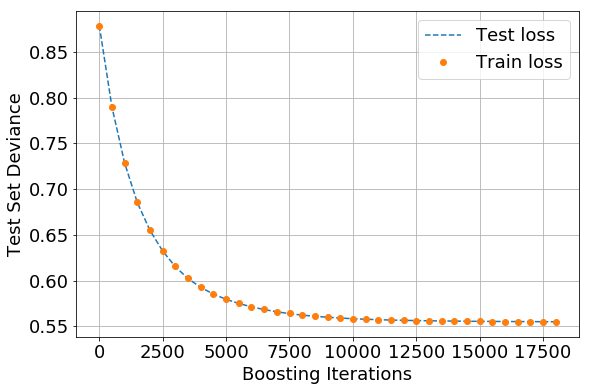

In [52]:
plotEvery = 500
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(9,6))
plt.plot((np.arange(test_deviance.shape[0]) + 1)[::plotEvery], test_deviance[::plotEvery], '--', label='Test loss')
plt.plot((np.arange(train_deviance.shape[0]) + 1)[::plotEvery], train_deviance[::plotEvery], 'o', label='Train loss')
plt.legend(loc='best')
plt.xlabel('Boosting Iterations')
plt.ylabel('Test Set Deviance')
# plt.yscale('log')
plt.grid()
plt.show()
fig.savefig('./kinObsMVA/trainHistory_clfGBC_tauVall_{}{}.png'.format(version, cat.name))

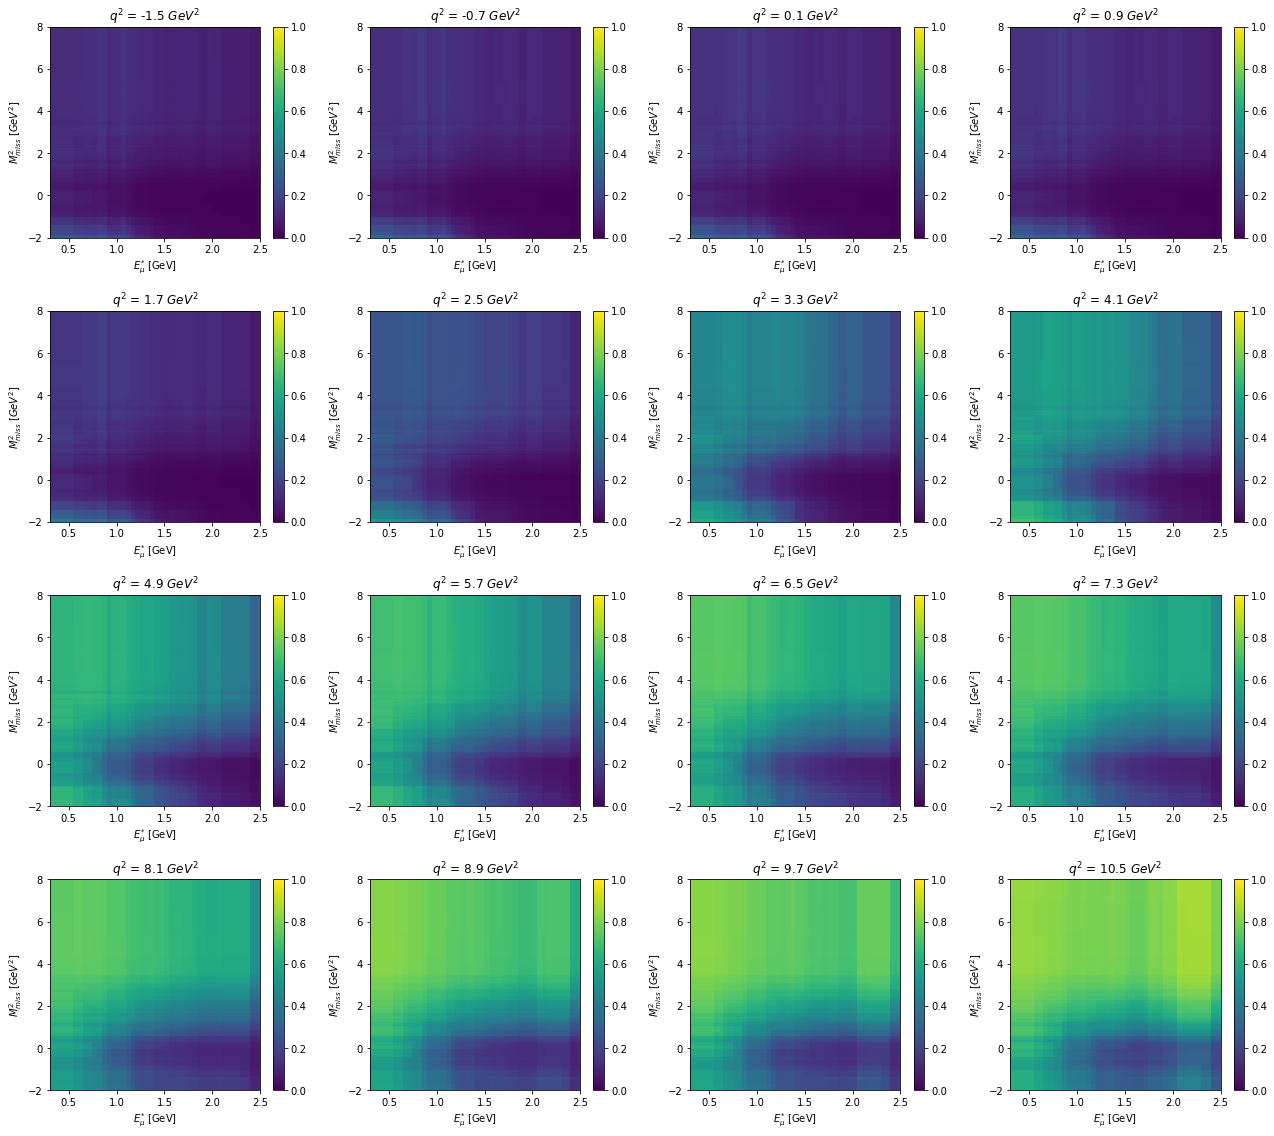

In [25]:
xq2 = np.arange(-1.9, 11.1, 0.8)
limEstMu = [0.3,2.5, 0.05]
limM2miss = [-2, 8.0, 0.05]

x = np.arange(limEstMu[0], limEstMu[1]+limEstMu[2], limEstMu[2])
x = 0.5*(x[:-1] + x[1:])
y = np.arange(limM2miss[0], limM2miss[1]+limM2miss[2], limM2miss[2])
y = 0.5*(y[:-1] + y[1:])
x2 = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
# print x.shape, y.shape, x2.shape

y, x = np.mgrid[slice(limM2miss[0], limM2miss[1]+limM2miss[2], limM2miss[2]),
                slice(limEstMu[0], limEstMu[1]+limEstMu[2], limEstMu[2])]
# print x.shape
# print y.shape

# print x
# print y
# print
# print x2[:,0].reshape(x.shape[0]-1, x.shape[1]-1)

fig, axes = plt.subplots(4,4, figsize=(18,16))
for i in range(xq2.shape[0] - 1):
# i=3
    ax = axes[i/4, i%4]

    auxq2 = 0.5*(xq2[i] + xq2[i+1])*np.ones(x2.shape[0])
    xIn = np.column_stack((auxq2, x2))
    p = clfGBC.predict_proba(xIn)
    p = p[:,1].reshape(x.shape[0]-1, x.shape[1]-1)
    c = ax.pcolorfast(x, y, p, cmap='viridis', vmin=0, vmax=1)
    fig.colorbar(c, ax=ax)
    ax.set_xlabel(r'$E^{*}_{\mu}$ [GeV]')
    ax.set_ylabel('$M^{2}_{miss}$ '+'$[GeV^2]$')
    ax.set_title('$q^2$ = '+'{:.1f} '.format(auxq2[0]) + '$GeV^2$')

fig.tight_layout(pad=1.5)
fig.savefig('./kinObsMVA/scoreMap_clfGBC_tauVall_{}{}.png'.format(version, cat.name))

In [26]:
histos = {}
for n in sampleX.keys():
    print n
    p = clfGBC.predict_proba(sampleX[n])
    histos[n] = create_TH1D(p[:,1], name='h'+n, binning=[80, 0, 1.2], weights=sampleWeights[n],
                            axis_title=['GBC predicted probability', 'Expected events'])
histos['data'] = histos['mu'].Clone('placeholderData')
histos['data'].Reset()

tau
DstmD0
BmDstmHc
DstPipPi0
DstPi0
antiB0DstmHc
mu
DstmDsp
DstPip
DstPipPim
DstmDp
BpDstmHc
DstPi0Pi0


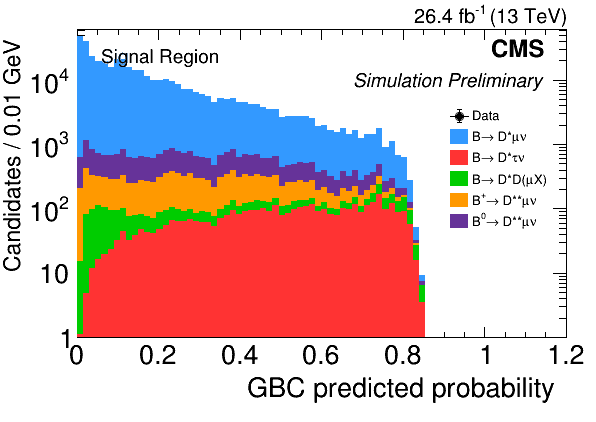

In [27]:
c = plot_SingleCategory(CMS_lumi, histos,
                        addText='Signal Region', min_y=1, tag='log', logy=True,
                        legLoc=[0.75, 0.45, 0.92, 0.75],
                        procOrder = ['tau', 'DstD', 'Dstst', 'mu']
                       )
c.Draw()
c.SaveAs('./kinObsMVA/scores_clfGBC_tauVall_{}{}.png'.format(version, cat.name))

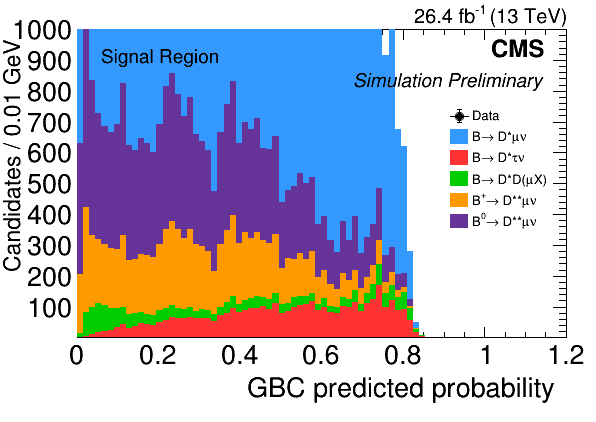

In [28]:
C = plot_SingleCategory(CMS_lumi, histos,
                        addText='Signal Region', min_y=1, tag='lin', logy=False,
                        legLoc=[0.75, 0.45, 0.92, 0.75],
                        procOrder = ['tau', 'DstD', 'Dstst', 'mu'],
                        max_y = 1000
                       )
C.Draw()

In [29]:
raise

TypeError: exceptions must be old-style classes or derived from BaseException, not NoneType

# Three samples (Tau vs Mu vs Bkg)

In [ ]:
weightsBkg = np.array([])
xBkg = np.zeros((0,3))
for n in sampleWeights.keys():
    if not n in ['tau', 'mu']:
        weightsBkg = np.concatenate((weightsBkg, sampleWeights[n]))
        xBkg = np.concatenate((xBkg, sampleX[n]))

wTot = np.sum(weightsBkg) + np.sum(sampleWeights['tau']) + np.sum(sampleWeights['mu'])
fBkg = np.sum(weightsBkg)/wTot
fTau = np.sum(sampleWeights['tau'])/wTot
fMu = np.sum(sampleWeights['mu'])/wTot
print fTau, fMu, fBkg

In [ ]:
X = np.concatenate((xBkg, sampleX['tau'], sampleX['mu']))
weights = np.concatenate((weightsBkg/fBkg, sampleWeights['tau']/fTau, sampleWeights['mu']/fMu))

yBkg = 0*np.ones_like(weightsBkg)
yMu = 1*np.ones_like(sampleWeights['mu'])
yTau = 2*np.ones_like(sampleWeights['tau'])
y = np.concatenate((yBkg, yTau, yMu))

In [ ]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=0)

## GBC Classifier

In [ ]:
fname = './kinObsMVA/clfGBC_bkgVmuVtau_{}{}.p'.format(version, cat.name)
if reTrain or not os.path.exists(fname):
    clfGBC = GradientBoostingClassifier(
        learning_rate=0.001, 
        n_estimators=1000, 
        min_samples_split=5, 
        min_weight_fraction_leaf=1e-3, 
        max_depth=3, 
        verbose=1,
        random_state=0
    )

    clfGBC.fit(X_train, y_train, sample_weight=w_train)

    sTrain = clfGBC.score(X_train, y_train, sample_weight=w_train)
    sTest = clfGBC.score(X_test, y_test, sample_weight=w_test)
    print 'Accuracy: {:.5f} (train), {:.5f} (test)'.format(sTrain, sTest)
    pickle.dump(clfGBC, open(fname, 'wb')) 
else:
    clfGBC = pickle.load(open(fname, 'rb'))

In [ ]:
pMu = clfGBC.predict_proba(sampleX['mu'])
pTau = clfGBC.predict_proba(sampleX['tau'])
pBkg = clfGBC.predict_proba(xBkg)

In [ ]:
probs = [pMu, pTau, pBkg]
weights = [sampleWeights['mu'], sampleWeights['tau'], weightsBkg]
tag = ['mu', 'tau', 'bkg']
dnd = []
for p, w, t in zip(probs, weights, tag):
    h = create_TH2D(p[:, 1:], 
                    binning=[50,0,1,50,0,1], 
                    name='h2_'+t,
                    axis_title=['GBC p(#mu)', 'GBC p(#tau)', 'Events '+t], 
                    weights=w)
    dnd.append(drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag='c_'+t, mR=0.2))

In [ ]:
histos = {}
for n in sampleX.keys():
    p = clfGBC.predict_proba(sampleX[n])
    histos[n] = create_TH1D(p[:,2], name='h'+n, binning=[100, 0, 1], weights=sampleWeights[n],
                            axis_title=['GBC predicted Tau class probability', 'Expected events'])
histos['data'] = histos['mu'].Clone('placeholderData')
histos['data'].Reset()